# EDA Seasonal

In [1]:
import os
import sys
from typing import Dict, Any, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# Add the parent directory to sys.path to allow imports from monthly_forecasting
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

data_config = {
    "path_discharge": "../../../../data/discharge/digitized_kyrgyz_hydromet/kyrgyz_hydromet_discharge_daily_2000_2023_kgz_filtered_v2.csv",
    "path_forcing": "../../../../data/forcing/ERA5_krg/HRU00003_forcing_2000-2023.csv",
    "path_static_data": "../../../../GIS/ML_Sandro/ML_basin_attributes_v2.csv",
    "path_to_sla": "../../../../data/sla_silvan/fsc_sla_timeseries_gapfilled.csv",
    "path_to_nir": "../../../../data/sla_silvan/meanNIR_TS_allBasins.csv",
    "path_to_sca": None,
    "path_to_hru_shp": "../../../../GIS/ML_Sandro/HRU_KRG_ML_MODEL_BASINS/HRU_KRG_ML_MODEL_BASINS_1d.shp",
    "path_to_swe": "../../../../data/snow/kyrgyzstan_ts/SWE",
    "path_to_hs": "../../../../data/snow/kyrgyzstan_ts/HS",
    "path_to_rof": "../../../../data/snow/kyrgyzstan_ts/RoF",
    "HRU_SWE": "HRU_00003",
    "HRU_HS": "HRU_00003",
    "HRU_ROF": "HRU_00003",
    "model_home_path": "../../monthly_forecasting_models/SnowMapper_Based",
}

## Data Loading

In [2]:
from monthly_forecasting.scr import data_loading as dl

# supress logging from matplotlib
import logging

logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def load_data(data_config: Dict[str, Any], path_config: Dict[str, Any]) -> tuple:
    """
    Load data using the data loading utilities.

    Args:
        data_config: Data configuration
        path_config: Path configuration

    Returns:
        Tuple of (data, static_data)
    """
    # -------------- 1. Load Data ------------------------------
    hydro_ca, static_df = dl.load_data(
        path_discharge=path_config["path_discharge"],
        path_forcing=path_config["path_forcing"],
        path_static_data=path_config["path_static_data"],
        path_to_sca=path_config["path_to_sca"],
        path_to_swe=path_config["path_to_swe"],
        path_to_hs=path_config["path_to_hs"],
        path_to_rof=path_config["path_to_rof"],
        HRU_SWE=path_config["HRU_SWE"],
        HRU_HS=path_config["HRU_HS"],
        HRU_ROF=path_config["HRU_ROF"],
        path_to_sla=path_config.get("path_to_sla", None),
        path_to_nir=path_config.get("path_to_nir", None),
    )

    # if log_discharge in columns - drop
    if "log_discharge" in hydro_ca.columns:
        hydro_ca.drop(columns=["log_discharge"], inplace=True)

    hydro_ca = hydro_ca.sort_values("date")

    hydro_ca["code"] = hydro_ca["code"].astype(int)

    if "CODE" in static_df.columns:
        static_df.rename(columns={"CODE": "code"}, inplace=True)
    static_df["code"] = static_df["code"].astype(int)

    return hydro_ca, static_df


# Load the data
hydro_ca, static_df = load_data(data_config, data_config)

print("Data loaded successfully.")

# get the dimensions of the data
print(f"hydro_ca shape: {hydro_ca.shape}")


Error loading SCA data: Invalid file path or buffer object type: <class 'NoneType'>


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/monthly_forecasting/scr/data_loading.py:87: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_file)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/monthly_forecasting/scr/data_loading.py:87: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path

Unique days of month in SLA data: [ 1 11 21]
Unique days of month after SLA data shift: [10 20 31 30]
Data loaded successfully.
hydro_ca shape: (552554, 18)
Data loaded successfully.
hydro_ca shape: (552554, 18)


## Feature Config

In [3]:
feature_config = {
    "discharge": [
        {
            "operation": "mean",
            "windows": [
                30,
            ],
            "lags": {},
        },
    ],
    "P": [{"operation": "sum", "windows": [90], "lags": {}}],
    "T": [{"operation": "mean", "windows": [30], "lags": {}}],
    "fsc_basin": [{"operation": "last_value", "windows": [10, 30], "lags": {}}],
    "SWE": [{"operation": "mean", "windows": [10,], "lags": {}},
            {"operation": "max", "windows": [90], "lags": {}}],
}

In [4]:
from monthly_forecasting.scr import FeatureExtractor as FE

# Use FeatureExtractor for time series features
extractor = FE.StreamflowFeatureExtractor(
    feature_configs=feature_config,
    prediction_horizon=180,
    offset=180,
)

data = extractor.create_all_features(hydro_ca)

# only keep the last day of the month
data = data[data["date"].dt.is_month_end]

data["month"] = data["date"].dt.month

2025-11-04 10:24:01,287 - monthly_forecasting.scr.FeatureExtractor - INFO - Creating features for column: discharge
2025-11-04 10:24:01,287 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'discharge': ['discharge']
2025-11-04 10:24:01,288 - monthly_forecasting.scr.FeatureExtractor - INFO - Configuration for column 'discharge': [{'operation': 'mean', 'windows': [30], 'lags': {}}]
2025-11-04 10:24:01,287 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'discharge': ['discharge']
2025-11-04 10:24:01,288 - monthly_forecasting.scr.FeatureExtractor - INFO - Configuration for column 'discharge': [{'operation': 'mean', 'windows': [30], 'lags': {}}]
2025-11-04 10:24:01,526 - monthly_forecasting.scr.FeatureExtractor - INFO - Creating features for column: P
2025-11-04 10:24:01,528 - monthly_forecasting.scr.FeatureExtractor - INFO - Features with column 'P': ['P']
2025-11-04 10:24:01,529 - monthly_forecasting.scr.FeatureExtractor - INFO - Configurat

## Seasonal Correlation

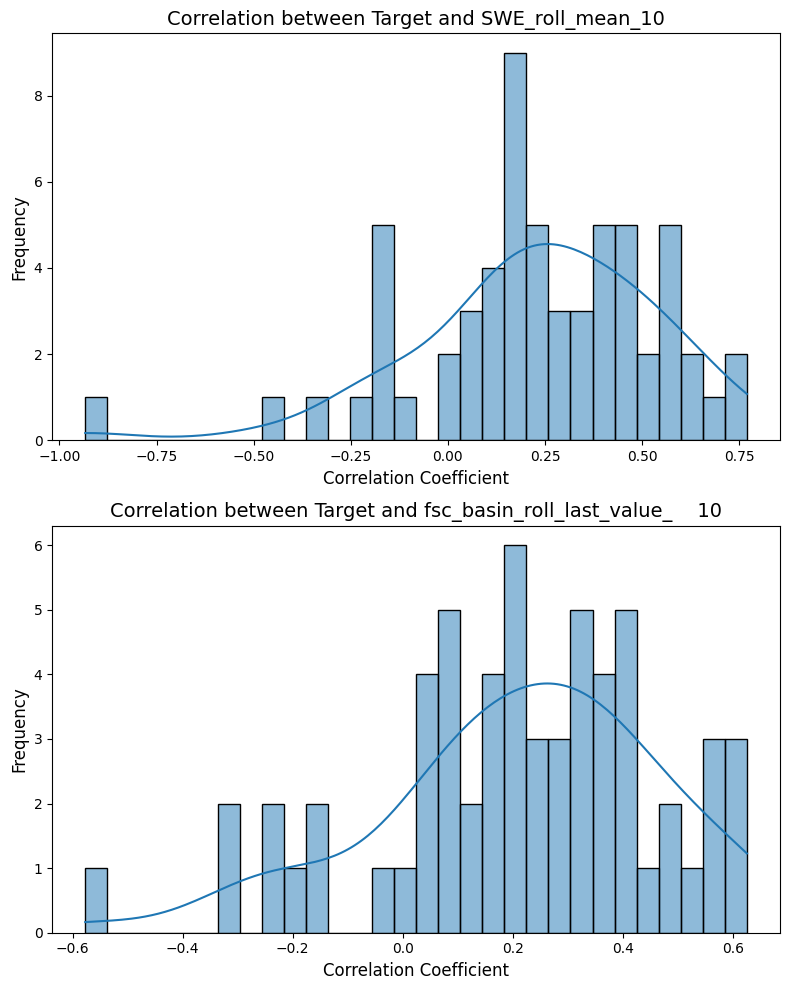

Code: 15049, Correlation between Target and SWE_roll_mean_10: -0.17782480807883475
Code: 15070, Correlation between Target and SWE_roll_mean_10: -0.16764248885720678
Code: 15039, Correlation between Target and SWE_roll_mean_10: 0.19788446947171034
Code: 15214, Correlation between Target and SWE_roll_mean_10: -0.14962022688602855
Code: 15194, Correlation between Target and SWE_roll_mean_10: -0.16458014813591396
Code: 15045, Correlation between Target and SWE_roll_mean_10: 0.12665288918108725
Code: 15044, Correlation between Target and SWE_roll_mean_10: 0.02160586475410051
Code: 16153, Correlation between Target and SWE_roll_mean_10: 0.06176730712514241
Code: 15090, Correlation between Target and SWE_roll_mean_10: -0.22185024086554012
Code: 16070, Correlation between Target and SWE_roll_mean_10: 0.18734878254431778
Code: 15083, Correlation between Target and SWE_roll_mean_10: -0.3100696116986952
Code: 15287, Correlation between Target and SWE_roll_mean_10: 0.15594931734521855
Code: 15069

In [5]:
features_corr = ['target', 'SWE_roll_mean_10', 'fsc_basin_roll_last_value_10']
data_march = data[data["month"] == 3].copy()
unique_codes = data_march["code"].unique()


all_correlations = pd.DataFrame()
for code in unique_codes:
    data_code = data_march[data_march["code"] == code]
    # filter out nan values
    data_code = data_code[features_corr].dropna()
    if data_code.shape[0] < 4:
        continue
    corr_month = data_code.corr()
    corr_month["code"] = code
    all_correlations = pd.concat([all_correlations, corr_month], axis=0)

# Plot correlation distribution for swe and fsc
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
sns.histplot(all_correlations["target"]["SWE_roll_mean_10"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Correlation between Target and SWE_roll_mean_10", fontsize=14)
axes[0].set_xlabel("Correlation Coefficient", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)    

sns.histplot(all_correlations["target"]["fsc_basin_roll_last_value_10"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Correlation between Target and fsc_basin_roll_last_value_    10", fontsize=14)
axes[1].set_xlabel("Correlation Coefficient", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)    

plt.tight_layout()
plt.show()


# print all basins where correlation between target and swe is less than 0.2
for code in unique_codes:
    if code not in all_correlations["code"].values:
        continue
    corr_value = all_correlations[all_correlations["code"] == code]["target"]["SWE_roll_mean_10"]
    if corr_value < 0.2:
        print(f"Code: {code}, Correlation between Target and SWE_roll_mean_10: {corr_value}")



## LOOCV Linear Regression Analysis

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

# Prepare data for March
data_march_clean = data_march[['code', 'target', 'SWE_roll_mean_10', 'fsc_basin_roll_last_value_10']].dropna()

# Initialize results storage
loocv_results = []

# Iterate through each basin (code)
for code in unique_codes:
    data_code = data_march_clean[data_march_clean["code"] == code].copy()
    
    # Skip if insufficient data
    if data_code.shape[0] < 4:
        continue
    
    # Prepare features and target
    X_swe = data_code[['SWE_roll_mean_10']].values
    X_fsc = data_code[['fsc_basin_roll_last_value_10']].values
    y = data_code['target'].values
    
    # LOOCV for SWE
    loo = LeaveOneOut()
    y_pred_swe = np.zeros(len(y))
    
    for train_idx, test_idx in loo.split(X_swe):
        X_train, X_test = X_swe[train_idx], X_swe[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Fit linear regression
        lr_swe = LinearRegression()
        lr_swe.fit(X_train, y_train)
        
        # Predict
        y_pred_swe[test_idx] = lr_swe.predict(X_test)
    
    # Calculate R² for SWE
    r2_swe = r2_score(y, y_pred_swe)
    
    # LOOCV for FSC
    y_pred_fsc = np.zeros(len(y))
    
    for train_idx, test_idx in loo.split(X_fsc):
        X_train, X_test = X_fsc[train_idx], X_fsc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Fit linear regression
        lr_fsc = LinearRegression()
        lr_fsc.fit(X_train, y_train)
        
        # Predict
        y_pred_fsc[test_idx] = lr_fsc.predict(X_test)
    
    # Calculate R² for FSC
    r2_fsc = r2_score(y, y_pred_fsc)
    
    # Store results
    loocv_results.append({
        'code': code,
        'r2_swe': r2_swe,
        'r2_fsc': r2_fsc,
        'n_samples': len(y)
    })

# Create DataFrame with results
loocv_df = pd.DataFrame(loocv_results)

# Clip R² values to [-1, 1]
loocv_df['r2_swe_clipped'] = loocv_df['r2_swe'].clip(-1, 1)
loocv_df['r2_fsc_clipped'] = loocv_df['r2_fsc'].clip(-1, 1)

print(f"Number of basins analyzed: {len(loocv_df)}")
print(f"\nSWE R² Statistics:")
print(f"  Mean: {loocv_df['r2_swe_clipped'].mean():.3f}")
print(f"  Median: {loocv_df['r2_swe_clipped'].median():.3f}")
print(f"  Std: {loocv_df['r2_swe_clipped'].std():.3f}")
print(f"\nFSC R² Statistics:")
print(f"  Mean: {loocv_df['r2_fsc_clipped'].mean():.3f}")
print(f"  Median: {loocv_df['r2_fsc_clipped'].median():.3f}")
print(f"  Std: {loocv_df['r2_fsc_clipped'].std():.3f}")

loocv_df.head(10)

Number of basins analyzed: 61

SWE R² Statistics:
  Mean: -0.117
  Median: -0.158
  Std: 0.220

FSC R² Statistics:
  Mean: -0.177
  Median: -0.182
  Std: 0.203


,code,r2_swe,r2_fsc,n_samples,r2_swe_clipped,r2_fsc_clipped
0,15049,-0.216029,-0.320797,13,-0.216029,-0.320797
1,16055,-0.155403,0.244334,22,-0.155403,0.244334
2,15278,-0.566363,-0.275412,13,-0.566363,-0.275412
3,15312,0.431784,-0.522143,12,0.431784,-0.522143
4,15070,-0.171879,-0.058915,19,-0.171879,-0.058915
5,16146,-0.192211,-0.487148,11,-0.192211,-0.487148
6,16121,-0.058924,-0.083842,18,-0.058924,-0.083842
7,16068,-0.164579,0.166028,20,-0.164579,0.166028
8,15039,-0.312010,-0.285571,22,-0.312010,-0.285571
9,16139,0.057135,-0.106230,17,0.057135,-0.106230


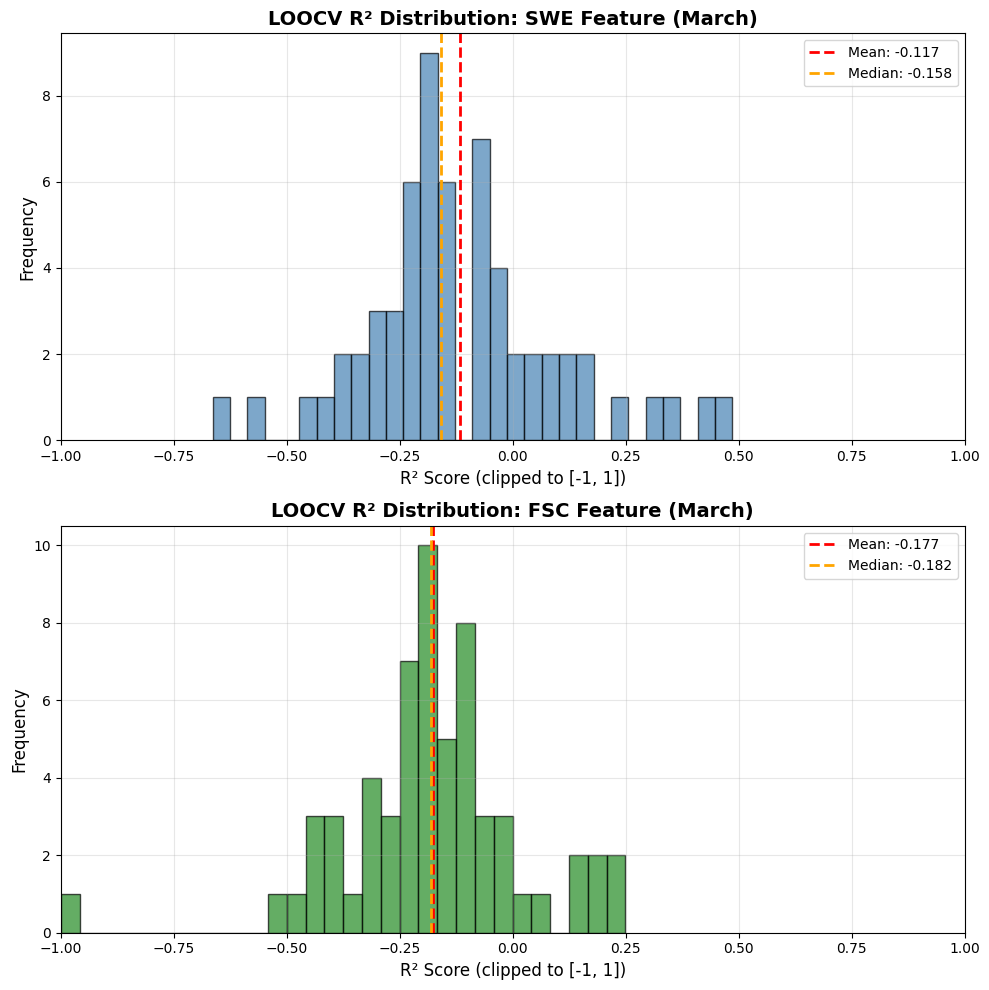

In [7]:
# Plot histograms of clipped R² values
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Histogram for SWE R²
axes[0].hist(loocv_df['r2_swe_clipped'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(loocv_df['r2_swe_clipped'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {loocv_df["r2_swe_clipped"].mean():.3f}')
axes[0].axvline(loocv_df['r2_swe_clipped'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {loocv_df["r2_swe_clipped"].median():.3f}')
axes[0].set_title('LOOCV R² Distribution: SWE Feature (March)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('R² Score (clipped to [-1, 1])', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xlim(-1, 1)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Histogram for FSC R²
axes[1].hist(loocv_df['r2_fsc_clipped'], bins=30, alpha=0.7, color='forestgreen', edgecolor='black')
axes[1].axvline(loocv_df['r2_fsc_clipped'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {loocv_df["r2_fsc_clipped"].mean():.3f}')
axes[1].axvline(loocv_df['r2_fsc_clipped'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {loocv_df["r2_fsc_clipped"].median():.3f}')
axes[1].set_title('LOOCV R² Distribution: FSC Feature (March)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('R² Score (clipped to [-1, 1])', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xlim(-1, 1)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

## Time Series Analysis for Basins with Negative SWE Correlation

In [8]:
# Identify basins with negative correlation between target and SWE for March
negative_swe_basins = []

for code in unique_codes:
    if code not in all_correlations["code"].values:
        continue
    
    # Get correlation value for this basin
    corr_data = all_correlations[all_correlations["code"] == code]
    if len(corr_data) == 0:
        continue
        
    # Extract correlation between target and SWE
    try:
        corr_value = corr_data.iloc[0]["SWE_roll_mean_10"]  # target row, SWE column
        if corr_value < 0:  # Negative correlation
            negative_swe_basins.append({
                'code': code,
                'correlation': corr_value
            })
    except (KeyError, IndexError):
        continue

negative_swe_df = pd.DataFrame(negative_swe_basins)
print(f"Found {len(negative_swe_basins)} basins with negative SWE correlation in March:")
print(negative_swe_df.sort_values('correlation'))

Found 10 basins with negative SWE correlation in March:
    code  correlation
8  15016    -0.933572
6  15054    -0.475609
5  15083    -0.310070
4  15090    -0.221850
0  15049    -0.177825
9  15171    -0.171603
1  15070    -0.167642
3  15194    -0.164580
2  15214    -0.149620
7  15081    -0.096031


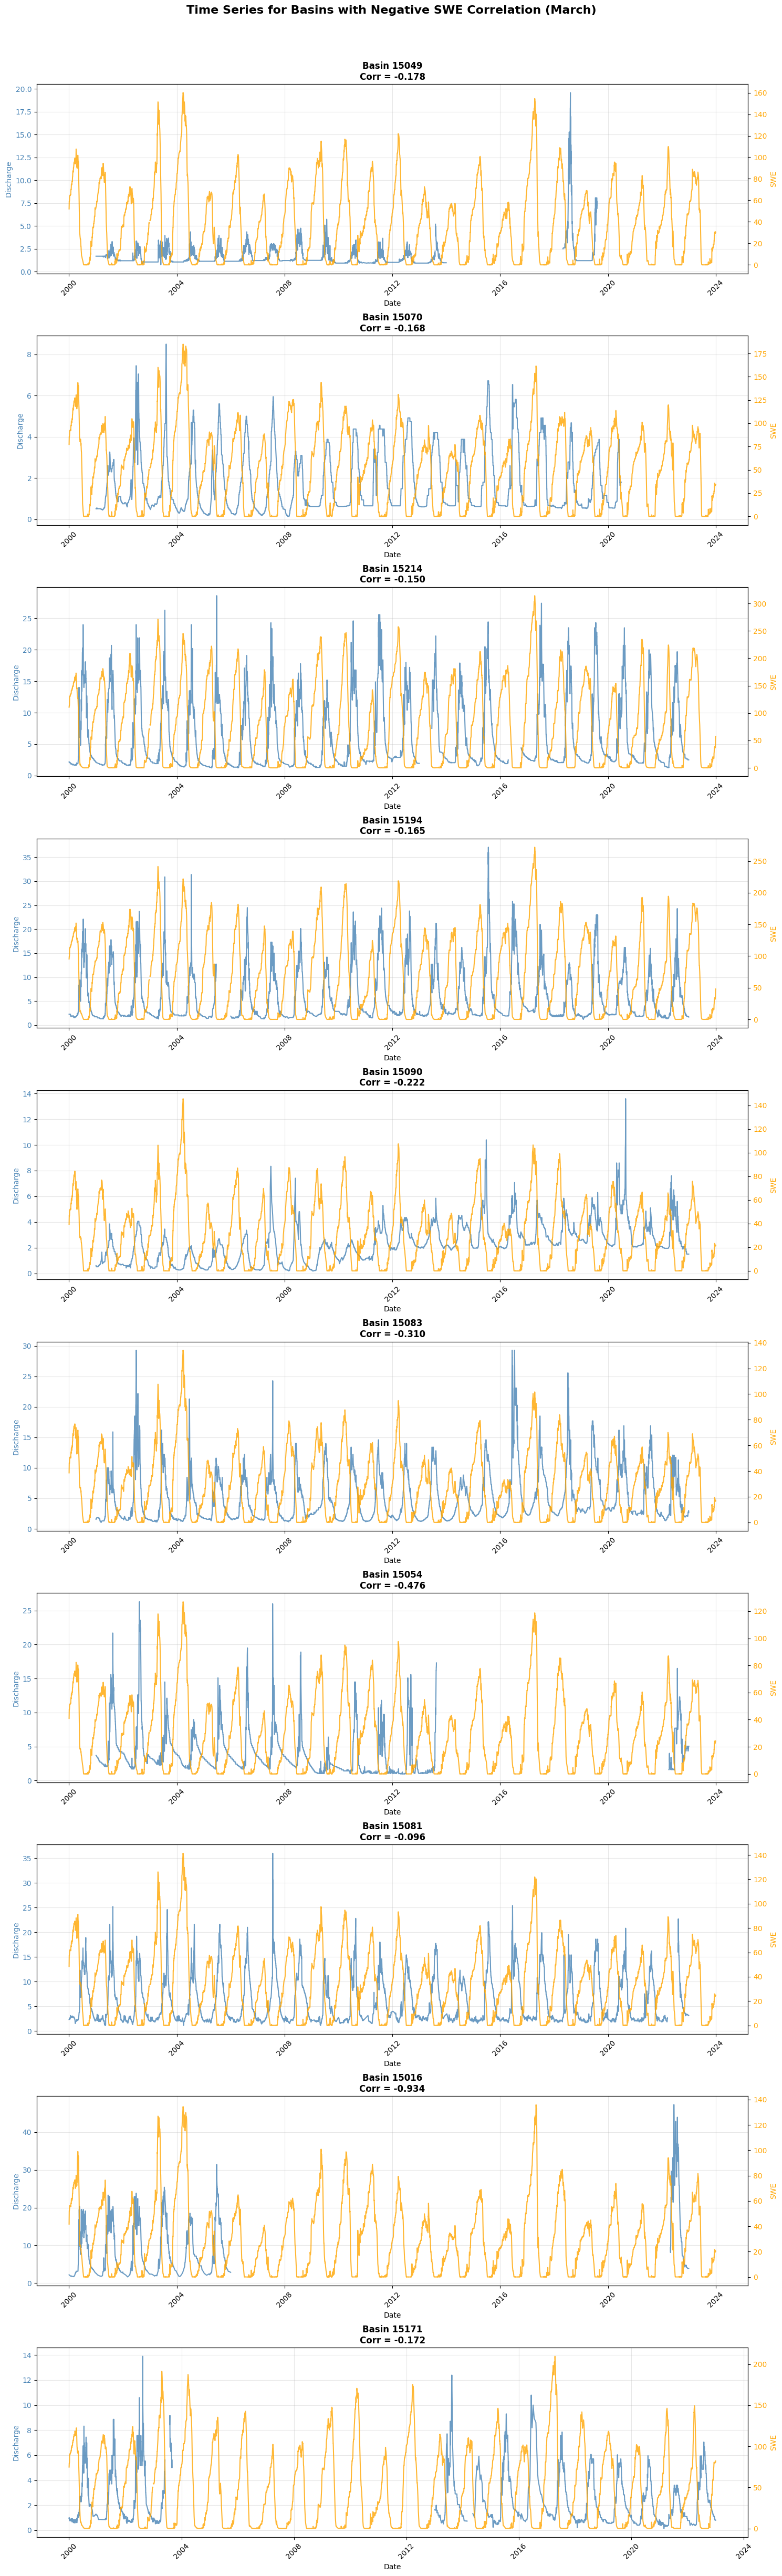

In [9]:
# Plot original time series for basins with negative SWE correlation
if len(negative_swe_basins) > 0:
    # Calculate subplot grid dimensions
    n_basins = len(negative_swe_basins)
    n_cols = 1  # Number of columns
    n_rows = (n_basins + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Ensure axes is always a 2D array for consistent indexing
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, basin_info in enumerate(negative_swe_basins):
        code = basin_info['code']
        correlation = basin_info['correlation']
        
        # Get data for this basin (all months, not just March)
        basin_data = hydro_ca[hydro_ca['code'] == code].copy()
        
        if len(basin_data) == 0:
            continue
            
        # Sort by date for proper time series plotting
        basin_data = basin_data.sort_values('date')
        
        # Calculate subplot position
        row = i // n_cols
        col = i % n_cols
        
        # Create the plot
        ax = axes[row, col]
        
        # Plot discharge (target) and SWE on different y-axes
        ax2 = ax.twinx()
        
        # Plot discharge on left y-axis
        line1 = ax.plot(basin_data['date'], basin_data['discharge'], 
                       color='steelblue', linewidth=1.5, label='Discharge', alpha=0.8)
        
        # Plot SWE on right y-axis (if SWE exists)
        if 'SWE' in basin_data.columns:
            line2 = ax2.plot(basin_data['date'], basin_data['SWE'], 
                            color='orange', linewidth=1.5, label='SWE', alpha=0.8)
        
        # Formatting
        ax.set_title(f'Basin {code}\nCorr = {correlation:.3f}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Discharge', fontsize=10, color='steelblue')
        ax2.set_ylabel('SWE', fontsize=10, color='orange')
        
        # Color the y-axis labels to match the lines
        ax.tick_params(axis='y', labelcolor='steelblue')
        ax2.tick_params(axis='y', labelcolor='orange')
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)
        
    # Hide unused subplots
    for i in range(len(negative_swe_basins), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.suptitle('Time Series for Basins with Negative SWE Correlation (March)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the main title
    plt.show()
    
else:
    print("No basins found with negative SWE correlation in March.")

## Multiple Linear Regression with Different Predictor Combinations

In [10]:
# Define predictor combinations for SWE and FSC models
swe_combinations = {
    'SWE_T_P_D': ['SWE_roll_mean_10', 'T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30'],
    'SWE_P': ['SWE_roll_mean_10', 'P_roll_sum_90'],
    'SWE_D': ['SWE_roll_mean_10', 'discharge_roll_mean_30'],
    'T_P_D': ['T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30'],
    'SWE' : ['SWE_roll_mean_10'],
}

fsc_combinations = {
    'FSC_T_P_D': ['fsc_basin_roll_last_value_10', 'T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30'],
    'FSC_P': ['fsc_basin_roll_last_value_10', 'P_roll_sum_90'],
    'FSC_D': ['fsc_basin_roll_last_value_10', 'discharge_roll_mean_30'],
    'T_P_D': ['T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30'],  # Same as above
    'FSC' : ['fsc_basin_roll_last_value_10']
}

# Prepare data for March with all required features
required_features = ['target', 'SWE_roll_mean_10', 'fsc_basin_roll_last_value_10', 
                    'T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30']

# Check which features are available in the data
available_features = [col for col in required_features if col in data_march.columns]
print(f"Available features: {available_features}")

# Use only available features for the analysis
data_march_reg = data_march[['code'] + available_features].dropna()
print(f"Data shape after removing NaN: {data_march_reg.shape}")
print(f"Available basins: {data_march_reg['code'].nunique()}")

Available features: ['target', 'SWE_roll_mean_10', 'fsc_basin_roll_last_value_10', 'T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30']
Data shape after removing NaN: (1125, 7)
Available basins: 63


In [11]:
# Function to fit regression models and calculate R²
def fit_regression_models(data, combinations, combination_type='SWE'):
    """
    Fit linear regression models for different predictor combinations.
    
    Args:
        data: DataFrame with features and target
        combinations: Dict with combination names and feature lists
        combination_type: String identifier for the type of combinations
    
    Returns:
        DataFrame with R² results for each basin and combination
    """
    results = []
    unique_codes = data['code'].unique()
    
    for code in unique_codes:
        basin_data = data[data['code'] == code].copy()
        
        # Skip if insufficient data
        if basin_data.shape[0] < 5:
            continue
            
        y = basin_data['target'].values
        
        # Fit models for each combination
        for combo_name, features in combinations.items():
            # Check if all features are available
            available_features = [f for f in features if f in basin_data.columns]
            
            if len(available_features) == 0:
                continue
                
            # Use only available features
            X = basin_data[available_features].values
            
            # Check for NaN values
            if np.isnan(X).any() or np.isnan(y).any():
                continue
                
            try:
                # Fit linear regression
                lr = LinearRegression()
                lr.fit(X, y)
                
                # Calculate R²
                y_pred = lr.predict(X)
                r2 = r2_score(y, y_pred)
                
                # Store results
                results.append({
                    'code': code,
                    'combination': combo_name,
                    'r2': r2,
                    'r2_clipped': np.clip(r2, -1, 1),
                    'n_samples': len(y),
                    'n_features': len(available_features),
                    'features_used': ', '.join(available_features),
                    'type': combination_type
                })
                
            except Exception as e:
                print(f"Error fitting model for basin {code}, combination {combo_name}: {e}")
                continue
    
    return pd.DataFrame(results)

# Fit SWE-based models
print("Fitting SWE-based regression models...")
swe_results = fit_regression_models(data_march_reg, swe_combinations, 'SWE')

# Fit FSC-based models  
print("Fitting FSC-based regression models...")
fsc_results = fit_regression_models(data_march_reg, fsc_combinations, 'FSC')

# Combine results
all_results = pd.concat([swe_results, fsc_results], ignore_index=True)

print(f"\nTotal model fits: {len(all_results)}")
print(f"SWE-based models: {len(swe_results)}")
print(f"FSC-based models: {len(fsc_results)}")

# Display summary statistics
print(f"\nR² Statistics by Combination:")
summary_stats = all_results.groupby(['type', 'combination'])['r2_clipped'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(3)
print(summary_stats)

Fitting SWE-based regression models...
Fitting FSC-based regression models...

Total model fits: 610
SWE-based models: 305
FSC-based models: 305

R² Statistics by Combination:
                  count   mean  median    std    min    max
type combination                                           
FSC  FSC             61  0.111   0.067  0.115  0.000  0.399
     FSC_D           61  0.292   0.272  0.187  0.002  0.724
     FSC_P           61  0.182   0.136  0.154  0.003  0.816
     FSC_T_P_D       61  0.399   0.400  0.196  0.078  1.000
     T_P_D           61  0.329   0.286  0.193  0.013  0.815
SWE  SWE             61  0.150   0.080  0.174  0.000  0.872
     SWE_D           61  0.324   0.291  0.236  0.021  0.930
     SWE_P           61  0.221   0.154  0.193  0.003  0.873
     SWE_T_P_D       61  0.411   0.375  0.225  0.029  1.000
     T_P_D           61  0.329   0.286  0.193  0.013  0.815

Total model fits: 610
SWE-based models: 305
FSC-based models: 305

R² Statistics by Combination:
      

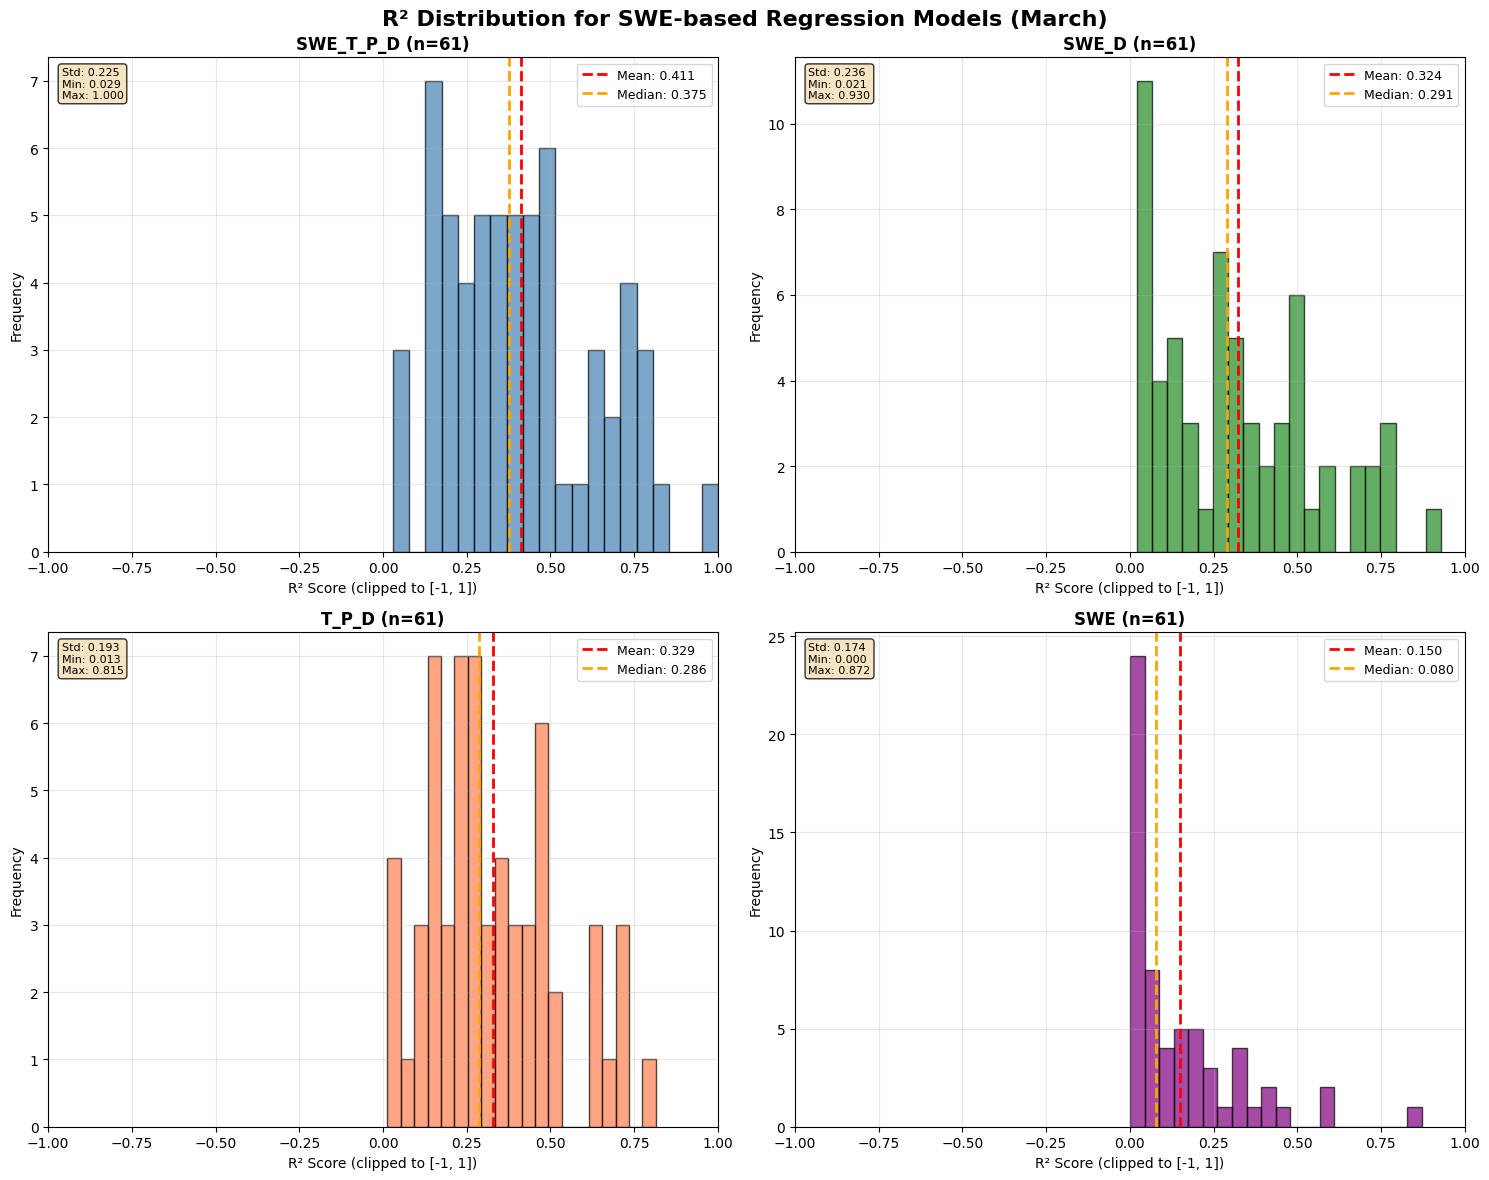

In [12]:
# Create histogram plots for SWE-based combinations
swe_combinations_order = ['SWE_T_P_D', 'SWE_D', 'T_P_D', 'SWE']
swe_data = swe_results[swe_results['combination'].isin(swe_combinations_order)]

if len(swe_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = ['steelblue', 'forestgreen', 'coral', 'purple']
    
    for i, combo in enumerate(swe_combinations_order):
        combo_data = swe_data[swe_data['combination'] == combo]['r2_clipped']
        
        if len(combo_data) > 0:
            ax = axes[i]
            
            # Create histogram
            ax.hist(combo_data, bins=20, alpha=0.7, color=colors[i], edgecolor='black')
            
            # Add statistics lines
            mean_val = combo_data.mean()
            median_val = combo_data.median()
            
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_val:.3f}')
            ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, 
                      label=f'Median: {median_val:.3f}')
            
            # Formatting
            ax.set_title(f'{combo} (n={len(combo_data)})', fontsize=12, fontweight='bold')
            ax.set_xlabel('R² Score (clipped to [-1, 1])', fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.set_xlim(-1, 1)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
            
            # Add text box with additional stats
            stats_text = f'Std: {combo_data.std():.3f}\nMin: {combo_data.min():.3f}\nMax: {combo_data.max():.3f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle('R² Distribution for SWE-based Regression Models (March)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No SWE-based results to plot")

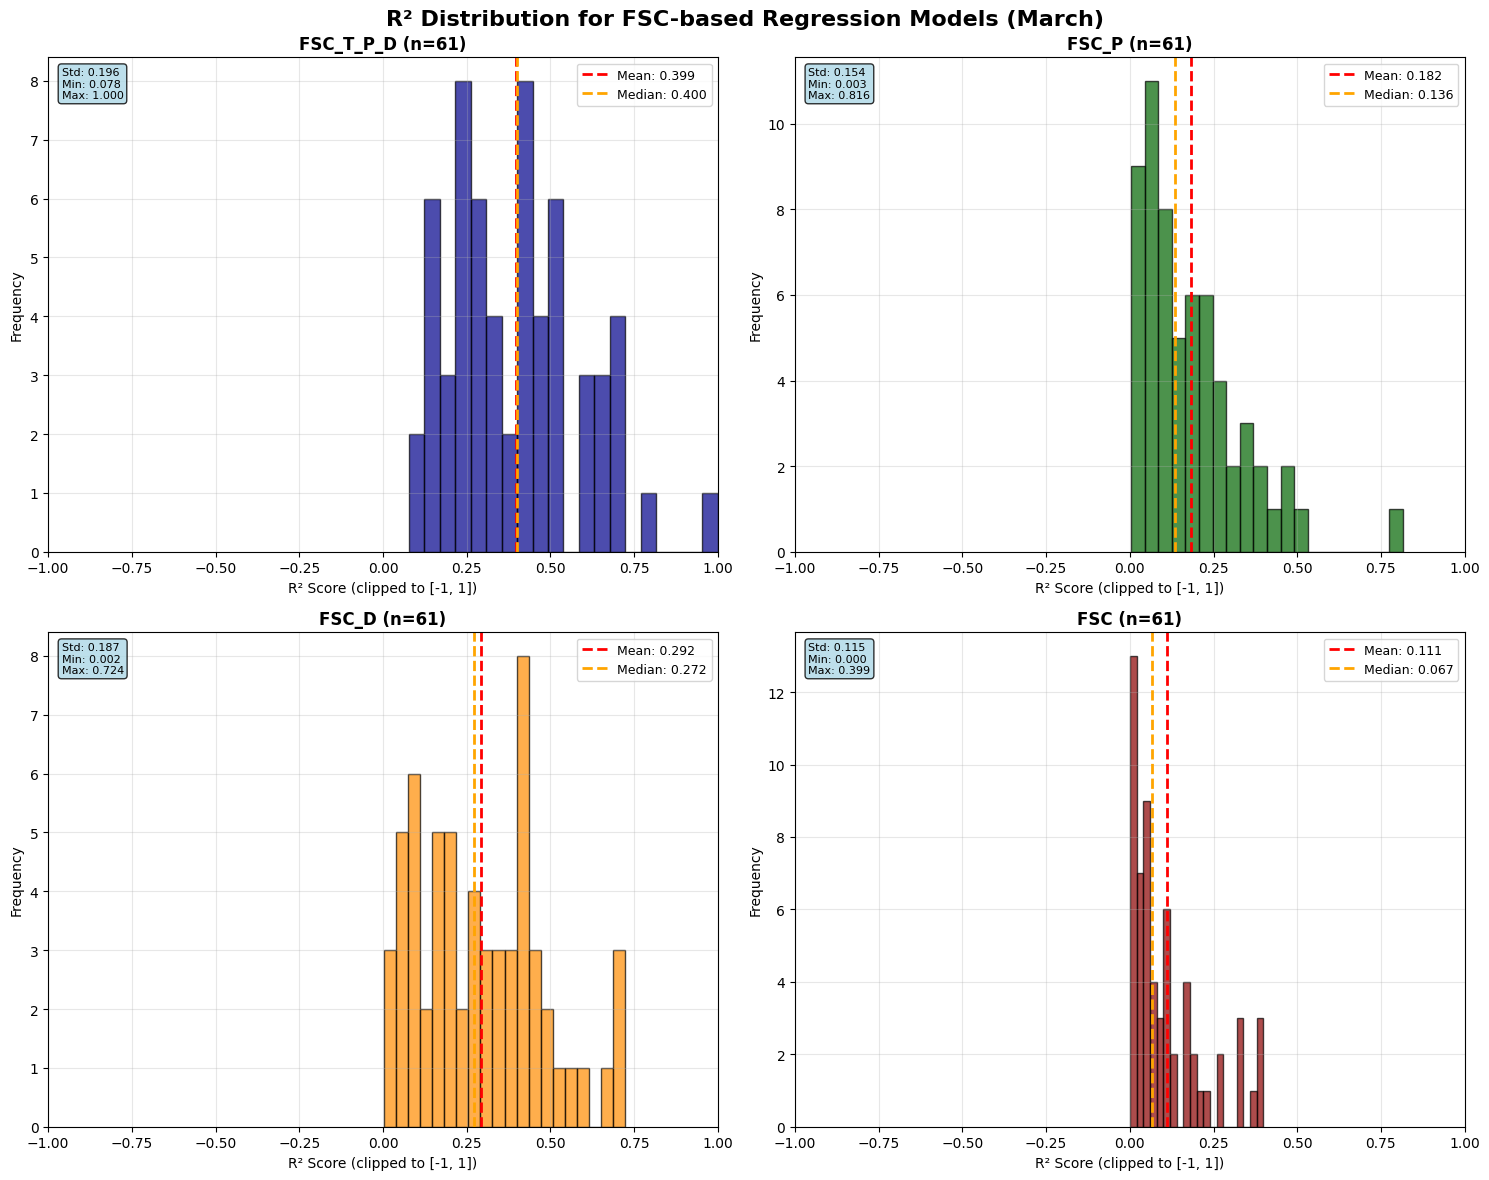

In [13]:
# Create histogram plots for FSC-based combinations
fsc_combinations_order = ['FSC_T_P_D', 'FSC_P', 'FSC_D', 'FSC']
fsc_data = fsc_results[fsc_results['combination'].isin(fsc_combinations_order)]

if len(fsc_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    colors = ['darkblue', 'darkgreen', 'darkorange', 'darkred']
    
    for i, combo in enumerate(fsc_combinations_order):
        combo_data = fsc_data[fsc_data['combination'] == combo]['r2_clipped']
        
        if len(combo_data) > 0:
            ax = axes[i]
            
            # Create histogram
            ax.hist(combo_data, bins=20, alpha=0.7, color=colors[i], edgecolor='black')
            
            # Add statistics lines
            mean_val = combo_data.mean()
            median_val = combo_data.median()
            
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_val:.3f}')
            ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, 
                      label=f'Median: {median_val:.3f}')
            
            # Formatting
            ax.set_title(f'{combo} (n={len(combo_data)})', fontsize=12, fontweight='bold')
            ax.set_xlabel('R² Score (clipped to [-1, 1])', fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.set_xlim(-1, 1)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
            
            # Add text box with additional stats
            stats_text = f'Std: {combo_data.std():.3f}\nMin: {combo_data.min():.3f}\nMax: {combo_data.max():.3f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=8,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('R² Distribution for FSC-based Regression Models (March)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No FSC-based results to plot")

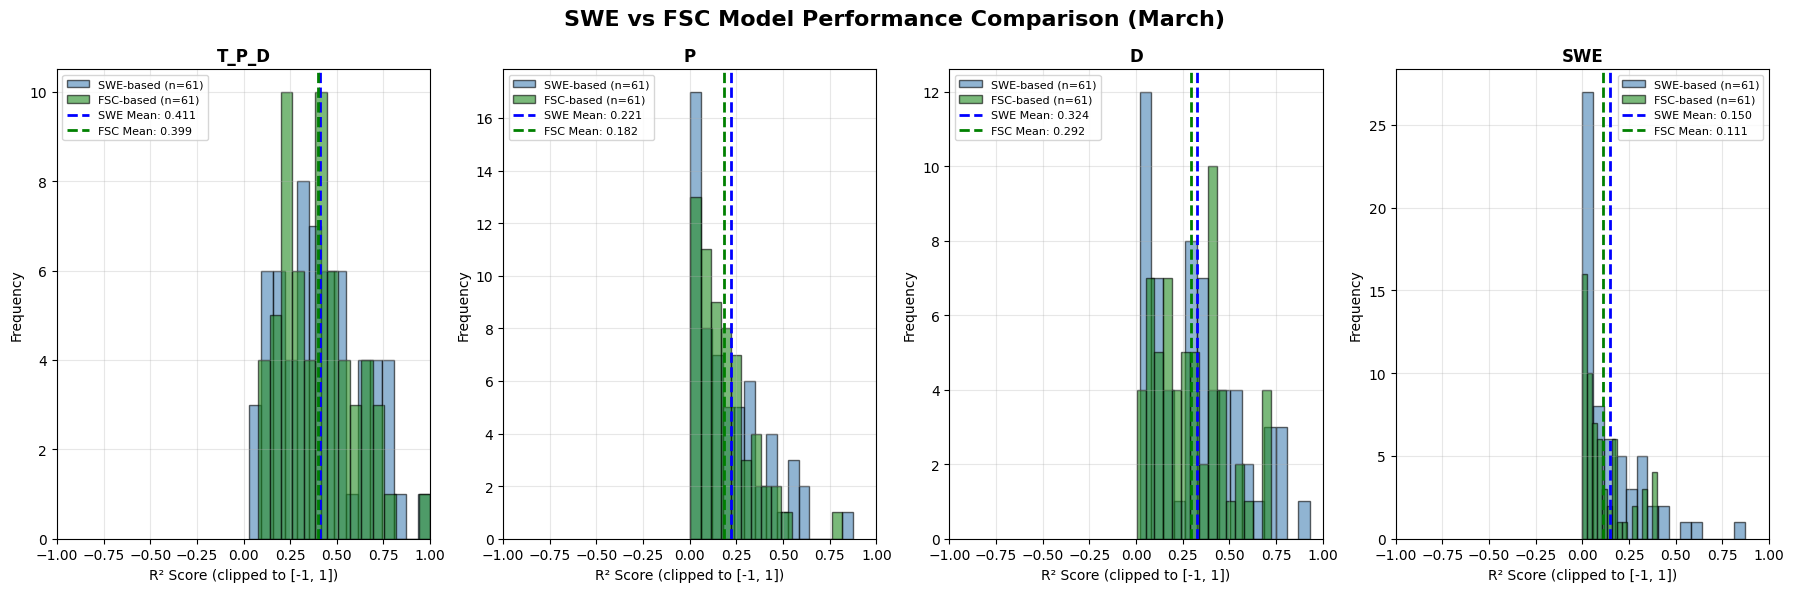


DETAILED COMPARISON STATISTICS

T+P+D:
  SWE-based: Mean=0.411, Std=0.225, n=61
  FSC-based: Mean=0.399, Std=0.196, n=61
  Difference (FSC - SWE): -0.013

P:
  SWE-based: Mean=0.221, Std=0.193, n=61
  FSC-based: Mean=0.182, Std=0.154, n=61
  Difference (FSC - SWE): -0.039

D:
  SWE-based: Mean=0.324, Std=0.236, n=61
  FSC-based: Mean=0.292, Std=0.187, n=61
  Difference (FSC - SWE): -0.032

SWE:
  SWE-based: Mean=0.150, Std=0.174, n=61
  FSC-based: Mean=0.111, Std=0.115, n=61
  Difference (FSC - SWE): -0.039

Results saved to 'regression_model_results.csv'
Total models fitted: 610
Unique basins: 61


In [14]:
# Comparison plot: SWE vs FSC for similar combinations
comparison_pairs = [
    ('SWE_T_P_D', 'FSC_T_P_D'),
    ('SWE_P', 'FSC_P'),
    ('SWE_D', 'FSC_D'),
    ('SWE', 'FSC')
]

fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i, (swe_combo, fsc_combo) in enumerate(comparison_pairs):
    ax = axes[i]
    
    # Get data for both combinations
    swe_combo_data = swe_results[swe_results['combination'] == swe_combo]['r2_clipped']
    fsc_combo_data = fsc_results[fsc_results['combination'] == fsc_combo]['r2_clipped']
    
    if len(swe_combo_data) > 0 and len(fsc_combo_data) > 0:
        # Create overlapping histograms
        ax.hist(swe_combo_data, bins=15, alpha=0.6, label=f'SWE-based (n={len(swe_combo_data)})', 
                color='steelblue', edgecolor='black')
        ax.hist(fsc_combo_data, bins=15, alpha=0.6, label=f'FSC-based (n={len(fsc_combo_data)})', 
                color='forestgreen', edgecolor='black')
        
        # Add mean lines
        ax.axvline(swe_combo_data.mean(), color='blue', linestyle='--', linewidth=2, 
                  label=f'SWE Mean: {swe_combo_data.mean():.3f}')
        ax.axvline(fsc_combo_data.mean(), color='green', linestyle='--', linewidth=2, 
                  label=f'FSC Mean: {fsc_combo_data.mean():.3f}')
    
    # Formatting
    combo_title = swe_combo.replace('SWE_', '').replace('FSC_', '')
    ax.set_title(f'{combo_title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('R² Score (clipped to [-1, 1])', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_xlim(-1, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('SWE vs FSC Model Performance Comparison (March)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed comparison statistics
print("\n" + "="*60)
print("DETAILED COMPARISON STATISTICS")
print("="*60)

for swe_combo, fsc_combo in comparison_pairs:
    swe_data = swe_results[swe_results['combination'] == swe_combo]['r2_clipped']
    fsc_data = fsc_results[fsc_results['combination'] == fsc_combo]['r2_clipped']
    
    if len(swe_data) > 0 and len(fsc_data) > 0:
        combo_name = swe_combo.replace('SWE_', '').replace('_', '+')
        print(f"\n{combo_name}:")
        print(f"  SWE-based: Mean={swe_data.mean():.3f}, Std={swe_data.std():.3f}, n={len(swe_data)}")
        print(f"  FSC-based: Mean={fsc_data.mean():.3f}, Std={fsc_data.std():.3f}, n={len(fsc_data)}")
        print(f"  Difference (FSC - SWE): {fsc_data.mean() - swe_data.mean():.3f}")

# Save results to CSV for further analysis
all_results.to_csv('regression_model_results.csv', index=False)
print(f"\nResults saved to 'regression_model_results.csv'")
print(f"Total models fitted: {len(all_results)}")
print(f"Unique basins: {all_results['code'].nunique()}")

## Hierarchical Linear Regression Analysis

In [15]:
# Install statsmodels if not available
try:
    import statsmodels.api as sm
    from statsmodels.formula.api import mixedlm
    print("Statsmodels is available")
except ImportError:
    raise ImportError("Please install statsmodels package to run mixed-effects modeling.")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut

Statsmodels is available


In [16]:
# Step 1: Preprocess features (z-score normalization per basin)
def preprocess_hierarchical_data(data):
    """
    Preprocess data for hierarchical regression with z-score normalization per basin.
    
    Args:
        data: DataFrame with features and target
        
    Returns:
        DataFrame with normalized features
    """
    # Define features to normalize
    features_to_normalize = ['SWE_roll_mean_10', 'T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30']
    
    # Check which features are available
    available_features = [f for f in features_to_normalize if f in data.columns]
    print(f"Features to normalize: {available_features}")
    
    # Create a copy of the data
    data_processed = data.copy()
    
    # Normalize features per basin (z-score normalization)
    for code in data['code'].unique():
        basin_mask = data_processed['code'] == code
        basin_data = data_processed.loc[basin_mask, available_features]
        
        # Skip if insufficient data
        if basin_data.shape[0] < 3:
            continue
            
        # Apply z-score normalization
        scaler = StandardScaler()
        data_processed.loc[basin_mask, available_features] = scaler.fit_transform(basin_data)
    
    # Rename columns to indicate they are normalized
    rename_dict = {f: f + '_norm' for f in available_features}
    data_processed = data_processed.rename(columns=rename_dict)
    
    return data_processed, available_features

# Prepare data for hierarchical modeling
print("Preprocessing data for hierarchical regression...")
hierarchical_features = ['target', 'SWE_roll_mean_10', 'T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30']
available_hier_features = [f for f in hierarchical_features if f in data_march.columns]

# Get clean data for hierarchical modeling
hier_data = data_march[['code'] + available_hier_features].dropna()
print(f"Data shape before preprocessing: {hier_data.shape}")

# Preprocess the data
hier_data_processed, normalized_features = preprocess_hierarchical_data(hier_data)
print(f"Data shape after preprocessing: {hier_data_processed.shape}")
print(f"Number of basins: {hier_data_processed['code'].nunique()}")

# Display first few rows
print("\nFirst few rows of processed data:")
print(hier_data_processed.head())

Preprocessing data for hierarchical regression...
Data shape before preprocessing: (1171, 6)
Features to normalize: ['SWE_roll_mean_10', 'T_roll_mean_30', 'P_roll_sum_90', 'discharge_roll_mean_30']
Data shape after preprocessing: (1171, 6)
Number of basins: 63

First few rows of processed data:
         code      target  SWE_roll_mean_10_norm  T_roll_mean_30_norm  \
307284  16055  178.298889              -0.034263            -1.530709   
263459  15278   12.011333              -0.627746            -1.918382   
298519  15312    8.253722              -0.903913            -1.449251   
438759  16146   40.102778              -0.160173            -1.656204   
377404  16121   35.606667              -0.874383            -1.395497   

        P_roll_sum_90_norm  discharge_roll_mean_30_norm  
307284           -0.899032                    -1.599283  
263459           -1.171936                    -0.585987  
298519           -1.385017                     0.851213  
438759           -1.293004       

In [20]:
# Step 2: Define hierarchical regression models with different parameter combinations
def fit_hierarchical_model(data, formula, model_name):
    """
    Fit a hierarchical linear regression model using mixed effects.
    
    Args:
        data: DataFrame with normalized features
        formula: String formula for the mixed effects model
        model_name: Name identifier for the model
        
    Returns:
        Dictionary with model results
    """
    try:
        # Fit mixed effects model
        model = mixedlm(formula, data, groups=data["code"])
        result = model.fit(method='lbfgs')
        
        # Calculate predictions and R²
        predictions = result.fittedvalues
        r2 = r2_score(data['target'], predictions)
        
        return {
            'model_name': model_name,
            'formula': formula,
            'model': result,
            'predictions': predictions,
            'r2': r2,
            'aic': result.aic,
            'bic': result.bic,
            'success': True,
            'error': None
        }
    
    except Exception as e:
        print(f"Error fitting {model_name}: {e}")
        return {
            'model_name': model_name,
            'formula': formula,
            'model': None,
            'predictions': None,
            'r2': None,
            'aic': None,
            'bic': None,
            'success': False,
            'error': str(e)
        }

# Define different hierarchical model combinations
# Format: formula, model_name
hierarchical_models = []

# Check which normalized features are available
norm_features = [f + '_norm' for f in normalized_features]
available_norm = [f for f in norm_features if f in hier_data_processed.columns]

print(f"Available normalized features: {available_norm}")

# Create model formulas based on available features
if 'SWE_roll_mean_10_norm' in available_norm and 'T_roll_mean_30_norm' in available_norm and 'P_roll_sum_90_norm' in available_norm and 'discharge_roll_mean_30_norm' in available_norm:
    
    
    
    # Model 4: Discharge fixed globally, SWE/T/P vary by basin
    hierarchical_models.append((
        "target ~ discharge_roll_mean_30_norm + SWE_roll_mean_10_norm + T_roll_mean_30_norm + P_roll_sum_90_norm",
        "SWE_regional",
        "SWE_roll_mean_10_norm"
    ))

    # Model 5: SWE fixed globally, SWE + T vary by basin
    hierarchical_models.append((
        "target ~ T_roll_mean_30_norm + discharge_roll_mean_30_norm + SWE_roll_mean_10_norm + P_roll_sum_90_norm",
        "SWE_T_regional",
        "SWE_roll_mean_10_norm + T_roll_mean_30_norm"
    ))

    # Model 4: Discharge fixed globally, SWE/T/P vary by basin
    hierarchical_models.append((
        "target ~ discharge_roll_mean_30_norm + SWE_roll_mean_10_norm + T_roll_mean_30_norm + P_roll_sum_90_norm",
        "SWE_discharge_regional",
        "SWE_roll_mean_10_norm + discharge_roll_mean_30_norm"
    ))

print(f"Defined {len(hierarchical_models)} hierarchical models to fit")

# Fit all hierarchical models
hierarchical_results = []

for fixed_formula, model_name, random_formula in hierarchical_models:
    print(f"\nFitting model: {model_name}")
    print(f"Fixed effects: {fixed_formula}")
    print(f"Random effects: {random_formula}")
    
    # Construct the full formula for mixedlm
    # In statsmodels, we specify random effects using re_formula
    try:
        model = mixedlm(fixed_formula, hier_data_processed, groups=hier_data_processed["code"], 
                       re_formula=random_formula)
        result = model.fit(method='lbfgs')
        
        # Calculate predictions and R²
        predictions = result.fittedvalues
        r2 = r2_score(hier_data_processed['target'], predictions)
        
        hierarchical_results.append({
            'model_name': model_name,
            'fixed_formula': fixed_formula,
            'random_formula': random_formula,
            'model': result,
            'predictions': predictions,
            'r2': r2,
            'r2_clipped': np.clip(r2, -1, 1),
            'aic': result.aic,
            'bic': result.bic,
            'success': True,
            'n_obs': len(predictions)
        })
        
        print(f"  R² = {r2:.4f}")
        print(f"  AIC = {result.aic:.2f}")
        print(f"  BIC = {result.bic:.2f}")
        
    except Exception as e:
        print(f"  Error: {e}")
        hierarchical_results.append({
            'model_name': model_name,
            'fixed_formula': fixed_formula,
            'random_formula': random_formula,
            'model': None,
            'predictions': None,
            'r2': None,
            'r2_clipped': None,
            'aic': None,
            'bic': None,
            'success': False,
            'n_obs': 0
        })

# Create summary DataFrame
hier_summary = pd.DataFrame([{
    'Model': result['model_name'],
    'R²': result['r2'],
    'R²_clipped': result['r2_clipped'],
    'AIC': result['aic'],
    'BIC': result['bic'],
    'Success': result['success'],
    'N_obs': result['n_obs']
} for result in hierarchical_results])

print("\n" + "="*60)
print("HIERARCHICAL MODEL SUMMARY")
print("="*60)
print(hier_summary)

Available normalized features: ['SWE_roll_mean_10_norm', 'T_roll_mean_30_norm', 'P_roll_sum_90_norm', 'discharge_roll_mean_30_norm']
Defined 3 hierarchical models to fit

Fitting model: SWE_regional
Fixed effects: target ~ discharge_roll_mean_30_norm + SWE_roll_mean_10_norm + T_roll_mean_30_norm + P_roll_sum_90_norm
Random effects: SWE_roll_mean_10_norm


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


  R² = 0.9685
  AIC = nan
  BIC = nan

Fitting model: SWE_T_regional
Fixed effects: target ~ T_roll_mean_30_norm + discharge_roll_mean_30_norm + SWE_roll_mean_10_norm + P_roll_sum_90_norm
Random effects: SWE_roll_mean_10_norm + T_roll_mean_30_norm


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

  R² = 0.9724
  AIC = nan
  BIC = nan

Fitting model: SWE_discharge_regional
Fixed effects: target ~ discharge_roll_mean_30_norm + SWE_roll_mean_10_norm + T_roll_mean_30_norm + P_roll_sum_90_norm
Random effects: SWE_roll_mean_10_norm + discharge_roll_mean_30_norm


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

  R² = 0.9737
  AIC = nan
  BIC = nan

HIERARCHICAL MODEL SUMMARY
                    Model        R²  R²_clipped  AIC  BIC  Success  N_obs
0            SWE_regional  0.968545    0.968545  NaN  NaN     True   1171
1          SWE_T_regional  0.972405    0.972405  NaN  NaN     True   1171
2  SWE_discharge_regional  0.973686    0.973686  NaN  NaN     True   1171


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
# Step 3: Implement yearly LOOCV for hierarchical models
def hierarchical_yearly_loocv(data, fixed_formula, random_formula, model_name):
    """
    Perform yearly Leave-One-Out Cross-Validation for hierarchical models.
    Leaves out one year at a time across all basins.
    
    Args:
        data: DataFrame with features and target (must have 'date' column)
        fixed_formula: Formula for fixed effects
        random_formula: Formula for random effects  
        model_name: Name of the model
        
    Returns:
        List of R² scores from yearly LOOCV
    """
    # Extract years from the data
    # We'll merge back with the original March data to get dates
    data_with_dates = data.merge(
        data_march[['code', 'target', 'date']], 
        on=['code', 'target'], 
        how='left'
    )
    
    # Get unique years
    data_with_dates['year'] = pd.to_datetime(data_with_dates['date']).dt.year
    unique_years = sorted(data_with_dates['year'].unique())
    
    yearly_loocv_r2_scores = []
    
    print(f"Performing yearly LOOCV for {model_name}...")
    print(f"  Available years: {unique_years}")
    
    for i, year_out in enumerate(unique_years):
        print(f"  Progress: {i+1}/{len(unique_years)} - Leaving out year {year_out}")
            
        try:
            # Split data: leave one year out across all basins
            train_data = data_with_dates[data_with_dates['year'] != year_out].copy()
            test_data = data_with_dates[data_with_dates['year'] == year_out].copy()
            
            # Skip if insufficient training or test data
            if len(train_data) < 20 or len(test_data) < 5:
                print(f"    Insufficient data for year {year_out}: train={len(train_data)}, test={len(test_data)}")
                continue
                
            # Remove date and year columns for modeling
            train_model_data = train_data.drop(columns=['date', 'year'], errors='ignore')
            test_model_data = test_data.drop(columns=['date', 'year'], errors='ignore')
                
            # Fit model on training data
            model = mixedlm(fixed_formula, train_model_data, groups=train_model_data["code"], 
                           re_formula=random_formula)
            result = model.fit(method='lbfgs', maxiter=100)
            
            # Make predictions on test data
            # For hierarchical models, we can predict using both fixed and random effects
            # since the basins in test set were seen during training (just different years)
            if hasattr(result, 'fittedvalues') and len(test_model_data) > 0:
                # Get predictions for test data
                test_predictions = result.predict(test_model_data)
                
                # Calculate R² for this year
                y_true = test_model_data['target'].values
                y_pred = test_predictions.values
                
                if len(y_true) > 1:
                    r2 = r2_score(y_true, y_pred)
                    yearly_loocv_r2_scores.append(np.clip(r2, -1, 1))
                    print(f"    Year {year_out}: R² = {r2:.4f} (n_test = {len(y_true)})")
                
        except Exception as e:
            print(f"    Error in year {year_out}: {e}")
            continue
    
    return yearly_loocv_r2_scores

# Perform LOOCV for successful hierarchical models
loocv_hierarchical_results = []

for result in hierarchical_results:
    if result['success']:
        model_name = result['model_name']
        fixed_formula = result['fixed_formula']
        random_formula = result['random_formula']
        
        # Perform yearly LOOCV
        loocv_scores = hierarchical_yearly_loocv(hier_data_processed, fixed_formula, 
                                        random_formula, model_name)
        
        if len(loocv_scores) > 0:
            loocv_hierarchical_results.append({
                'model_name': model_name,
                'loocv_r2_scores': loocv_scores,
                'loocv_r2_mean': np.mean(loocv_scores),
                'loocv_r2_std': np.std(loocv_scores),
                'loocv_r2_median': np.median(loocv_scores),
                'n_folds': len(loocv_scores),
                'full_data_r2': result['r2']
            })
            
            print(f"\nLOOCV Results for {model_name}:")
            print(f"  Mean R² = {np.mean(loocv_scores):.4f} ± {np.std(loocv_scores):.4f}")
            print(f"  Median R² = {np.median(loocv_scores):.4f}")
            print(f"  Number of folds = {len(loocv_scores)}")

# Create LOOCV summary DataFrame
loocv_hier_summary = pd.DataFrame(loocv_hierarchical_results)

print("\n" + "="*60)
print("HIERARCHICAL MODEL LOOCV SUMMARY")
print("="*60)
if len(loocv_hier_summary) > 0:
    display_cols = ['model_name', 'full_data_r2', 'loocv_r2_mean', 'loocv_r2_std', 'n_folds']
    print(loocv_hier_summary[display_cols].round(4))
else:
    print("No successful LOOCV results")

Performing yearly LOOCV for SWE_regional...
  Available years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
  Progress: 1/24 - Leaving out year 2000


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2000: R² = -0.0157 (n_test = 46)
  Progress: 2/24 - Leaving out year 2001


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2001: R² = -0.1483 (n_test = 59)
  Progress: 3/24 - Leaving out year 2002


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2002: R² = -0.0584 (n_test = 57)
  Progress: 4/24 - Leaving out year 2003


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2003: R² = -0.2226 (n_test = 51)
  Progress: 5/24 - Leaving out year 2004


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2004: R² = -0.0142 (n_test = 50)
  Progress: 6/24 - Leaving out year 2005


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2005: R² = 0.0015 (n_test = 48)
  Progress: 7/24 - Leaving out year 2006


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2006: R² = -0.0009 (n_test = 45)
  Progress: 8/24 - Leaving out year 2007


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2007: R² = -0.0096 (n_test = 51)
  Progress: 9/24 - Leaving out year 2008


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2008: R² = -0.0111 (n_test = 50)
  Progress: 10/24 - Leaving out year 2009


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2009: R² = -0.0092 (n_test = 49)
  Progress: 11/24 - Leaving out year 2010


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2010: R² = 0.0068 (n_test = 49)
  Progress: 12/24 - Leaving out year 2011


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2011: R² = 0.0096 (n_test = 48)
  Progress: 13/24 - Leaving out year 2012


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2012: R² = 0.0051 (n_test = 51)
  Progress: 14/24 - Leaving out year 2013


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2013: R² = -0.0102 (n_test = 48)
  Progress: 15/24 - Leaving out year 2014


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2014: R² = 0.0048 (n_test = 52)
  Progress: 16/24 - Leaving out year 2015


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2015: R² = 0.0029 (n_test = 50)
  Progress: 17/24 - Leaving out year 2016


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2016: R² = -0.0066 (n_test = 51)
  Progress: 18/24 - Leaving out year 2017


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2017: R² = -0.3004 (n_test = 51)
  Progress: 19/24 - Leaving out year 2018


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2018: R² = -0.6936 (n_test = 54)
  Progress: 20/24 - Leaving out year 2019


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2019: R² = 0.0006 (n_test = 56)
  Progress: 21/24 - Leaving out year 2020


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2020: R² = -0.0035 (n_test = 55)
  Progress: 22/24 - Leaving out year 2021


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2021: R² = -0.0066 (n_test = 51)
  Progress: 23/24 - Leaving out year 2022


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2022: R² = 0.0108 (n_test = 48)
  Progress: 24/24 - Leaving out year 2023
    Insufficient data for year 2023: train=1170, test=1

LOOCV Results for SWE_regional:
  Mean R² = -0.0639 ± 0.1552
  Median R² = -0.0066
  Number of folds = 23
Performing yearly LOOCV for SWE_T_regional...
  Available years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
  Progress: 1/24 - Leaving out year 2000


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2000: R² = -0.0159 (n_test = 46)
  Progress: 2/24 - Leaving out year 2001


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2001: R² = -0.1661 (n_test = 59)
  Progress: 3/24 - Leaving out year 2002


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2002: R² = -0.0618 (n_test = 57)
  Progress: 4/24 - Leaving out year 2003


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2003: R² = -0.2309 (n_test = 51)
  Progress: 5/24 - Leaving out year 2004


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2004: R² = -0.0155 (n_test = 50)
  Progress: 6/24 - Leaving out year 2005


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2005: R² = 0.0008 (n_test = 48)
  Progress: 7/24 - Leaving out year 2006


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2006: R² = -0.0012 (n_test = 45)
  Progress: 8/24 - Leaving out year 2007


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2007: R² = -0.0097 (n_test = 51)
  Progress: 9/24 - Leaving out year 2008


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2008: R² = -0.0112 (n_test = 50)
  Progress: 10/24 - Leaving out year 2009


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2009: R² = -0.0082 (n_test = 49)
  Progress: 11/24 - Leaving out year 2010


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2010: R² = 0.0063 (n_test = 49)
  Progress: 12/24 - Leaving out year 2011


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2011: R² = 0.0086 (n_test = 48)
  Progress: 13/24 - Leaving out year 2012


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2012: R² = 0.0046 (n_test = 51)
  Progress: 14/24 - Leaving out year 2013


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2013: R² = -0.0100 (n_test = 48)
  Progress: 15/24 - Leaving out year 2014


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2014: R² = 0.0043 (n_test = 52)
  Progress: 16/24 - Leaving out year 2015


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2015: R² = 0.0026 (n_test = 50)
  Progress: 17/24 - Leaving out year 2016


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2016: R² = -0.0052 (n_test = 51)
  Progress: 18/24 - Leaving out year 2017


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2017: R² = -0.3147 (n_test = 51)
  Progress: 19/24 - Leaving out year 2018


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2018: R² = -0.7354 (n_test = 54)
  Progress: 20/24 - Leaving out year 2019


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2019: R² = 0.0011 (n_test = 56)
  Progress: 21/24 - Leaving out year 2020


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2020: R² = -0.0032 (n_test = 55)
  Progress: 22/24 - Leaving out year 2021


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2021: R² = -0.0067 (n_test = 51)
  Progress: 23/24 - Leaving out year 2022


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2022: R² = 0.0122 (n_test = 48)
  Progress: 24/24 - Leaving out year 2023
    Insufficient data for year 2023: train=1170, test=1

LOOCV Results for SWE_T_regional:
  Mean R² = -0.0676 ± 0.1643
  Median R² = -0.0067
  Number of folds = 23
Performing yearly LOOCV for SWE_discharge_regional...
  Available years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
  Progress: 1/24 - Leaving out year 2000


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2000: R² = -0.0155 (n_test = 46)
  Progress: 2/24 - Leaving out year 2001


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2001: R² = -0.1418 (n_test = 59)
  Progress: 3/24 - Leaving out year 2002


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2002: R² = -0.0537 (n_test = 57)
  Progress: 4/24 - Leaving out year 2003


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2003: R² = -0.2253 (n_test = 51)
  Progress: 5/24 - Leaving out year 2004


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2004: R² = -0.0130 (n_test = 50)
  Progress: 6/24 - Leaving out year 2005


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2005: R² = 0.0016 (n_test = 48)
  Progress: 7/24 - Leaving out year 2006


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2006: R² = -0.0006 (n_test = 45)
  Progress: 8/24 - Leaving out year 2007


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2007: R² = -0.0105 (n_test = 51)
  Progress: 9/24 - Leaving out year 2008


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2008: R² = -0.0117 (n_test = 50)
  Progress: 10/24 - Leaving out year 2009


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2009: R² = -0.0091 (n_test = 49)
  Progress: 11/24 - Leaving out year 2010


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2010: R² = 0.0068 (n_test = 49)
  Progress: 12/24 - Leaving out year 2011


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2011: R² = 0.0099 (n_test = 48)
  Progress: 13/24 - Leaving out year 2012


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2012: R² = 0.0042 (n_test = 51)
  Progress: 14/24 - Leaving out year 2013


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2013: R² = -0.0102 (n_test = 48)
  Progress: 15/24 - Leaving out year 2014


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2014: R² = 0.0045 (n_test = 52)
  Progress: 16/24 - Leaving out year 2015


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2015: R² = 0.0031 (n_test = 50)
  Progress: 17/24 - Leaving out year 2016


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2016: R² = -0.0061 (n_test = 51)
  Progress: 18/24 - Leaving out year 2017


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2017: R² = -0.2959 (n_test = 51)
  Progress: 19/24 - Leaving out year 2018


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2018: R² = -0.6626 (n_test = 54)
  Progress: 20/24 - Leaving out year 2019


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2019: R² = 0.0010 (n_test = 56)
  Progress: 21/24 - Leaving out year 2020


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient opt

    Year 2020: R² = -0.0033 (n_test = 55)
  Progress: 22/24 - Leaving out year 2021


/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


    Year 2021: R² = -0.0061 (n_test = 51)
  Progress: 23/24 - Leaving out year 2022
    Year 2022: R² = 0.0099 (n_test = 48)
  Progress: 24/24 - Leaving out year 2023
    Insufficient data for year 2023: train=1170, test=1

LOOCV Results for SWE_discharge_regional:
  Mean R² = -0.0619 ± 0.1494
  Median R² = -0.0061
  Number of folds = 23

HIERARCHICAL MODEL LOOCV SUMMARY
               model_name  full_data_r2  loocv_r2_mean  loocv_r2_std  n_folds
0            SWE_regional        0.9685        -0.0639        0.1552       23
1          SWE_T_regional        0.9724        -0.0676        0.1643       23
2  SWE_discharge_regional        0.9737        -0.0619        0.1494       23
    Year 2022: R² = 0.0099 (n_test = 48)
  Progress: 24/24 - Leaving out year 2023
    Insufficient data for year 2023: train=1170, test=1

LOOCV Results for SWE_discharge_regional:
  Mean R² = -0.0619 ± 0.1494
  Median R² = -0.0061
  Number of folds = 23

HIERARCHICAL MODEL LOOCV SUMMARY
               model_nam

/Users/sandrohunziker/hydrosolutions Dropbox/Sandro Hunziker/SAPPHIRE_Central_Asia_Technical_Work/code/machine_learning_hydrology/monthly_forecasting/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


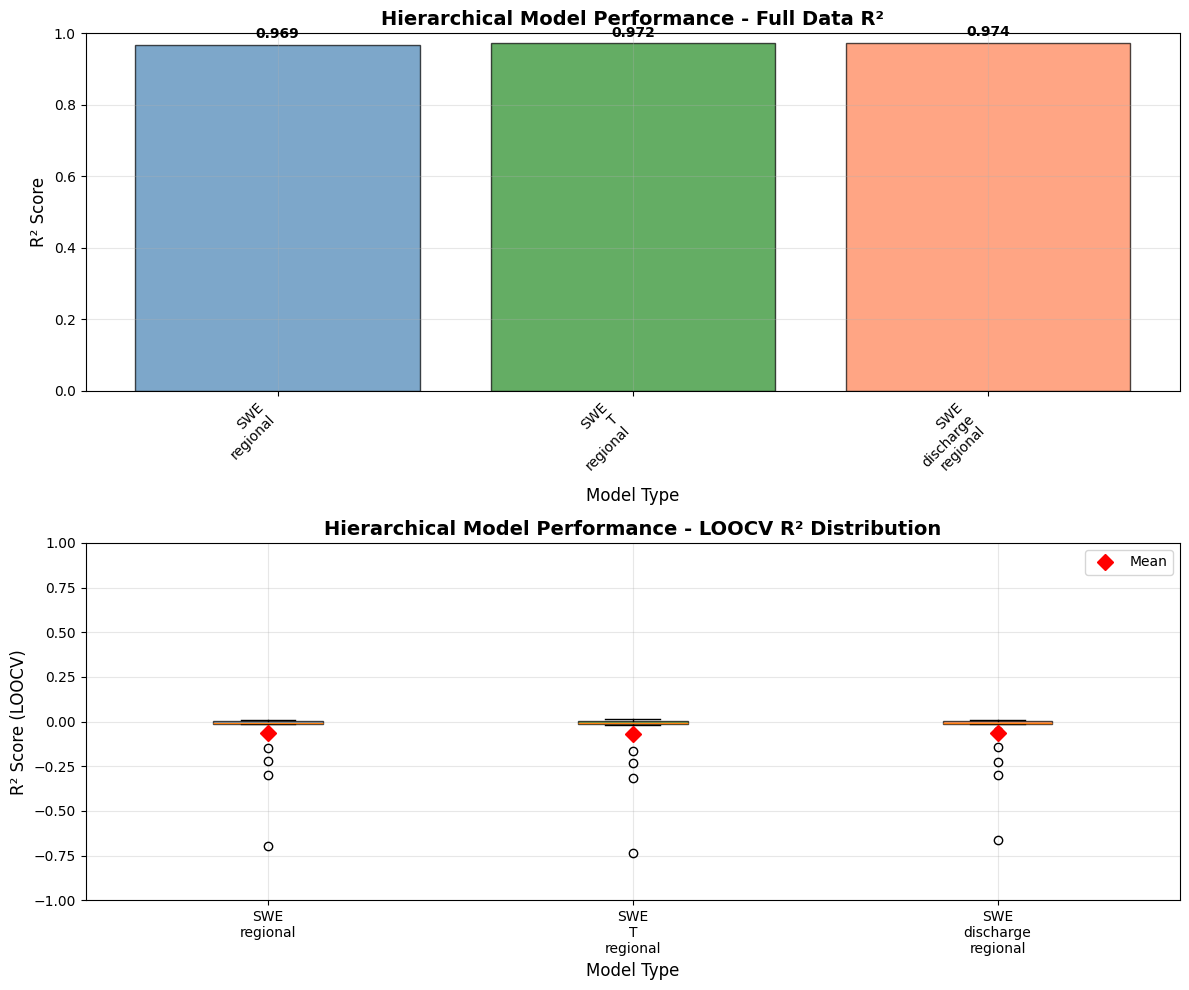

In [22]:
# Step 4: Visualize R² distributions for hierarchical models
# Plot full data R² distribution
successful_hier_results = [r for r in hierarchical_results if r['success']]

if len(successful_hier_results) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Full data R² distribution
    ax1 = axes[0]
    model_names = [r['model_name'] for r in successful_hier_results]
    r2_values = [r['r2_clipped'] for r in successful_hier_results]
    
    bars = ax1.bar(range(len(model_names)), r2_values, 
                   color=['steelblue', 'forestgreen', 'coral', 'purple', 'orange'][:len(model_names)],
                   alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, r2) in enumerate(zip(bars, r2_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_title('Hierarchical Model Performance - Full Data R²', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Model Type', fontsize=12)
    ax1.set_ylabel('R² Score', fontsize=12)
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels([name.replace('_', '\n') for name in model_names], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # LOOCV R² distributions (box plot)
    if len(loocv_hierarchical_results) > 0:
        ax2 = axes[1]
        
        loocv_data = []
        loocv_labels = []
        
        for result in loocv_hierarchical_results:
            loocv_data.append(result['loocv_r2_scores'])
            loocv_labels.append(result['model_name'].replace('_', '\n'))
        
        box_plot = ax2.boxplot(loocv_data, labels=loocv_labels, patch_artist=True)
        
        # Color the boxes
        colors = ['steelblue', 'forestgreen', 'coral', 'purple', 'orange']
        for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax2.set_title('Hierarchical Model Performance - LOOCV R² Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Model Type', fontsize=12)
        ax2.set_ylabel('R² Score (LOOCV)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(-1, 1)
        
        # Add mean markers
        for i, result in enumerate(loocv_hierarchical_results):
            mean_val = result['loocv_r2_mean']
            ax2.plot(i+1, mean_val, 'D', color='red', markersize=8, label='Mean' if i == 0 else '')
        
        ax2.legend()
    else:
        ax2 = axes[1]
        ax2.text(0.5, 0.5, 'No LOOCV results available', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=14)
        ax2.set_title('LOOCV Results - Not Available', fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful hierarchical models to plot")

In [23]:
# Detailed comparison: Hierarchical vs Individual Basin Models
print("\n" + "="*80)
print("HIERARCHICAL VS INDIVIDUAL BASIN MODEL COMPARISON")
print("="*80)

# Compare with individual basin models (from previous analysis)
if 'loocv_df' in locals():
    # Calculate statistics for individual basin models
    individual_stats = {
        'SWE Individual': {
            'mean_r2': loocv_df['r2_swe_clipped'].mean(),
            'median_r2': loocv_df['r2_swe_clipped'].median(),
            'std_r2': loocv_df['r2_swe_clipped'].std(),
            'n_basins': len(loocv_df)
        }
    }
    
    print("\nIndividual Basin Models (LOOCV):")
    for model, stats in individual_stats.items():
        print(f"  {model}:")
        print(f"    Mean R² = {stats['mean_r2']:.4f} ± {stats['std_r2']:.4f}")
        print(f"    Median R² = {stats['median_r2']:.4f}")
        print(f"    N basins = {stats['n_basins']}")

# Hierarchical model statistics
if len(loocv_hierarchical_results) > 0:
    print("\nHierarchical Models (LOOCV):")
    for result in loocv_hierarchical_results:
        print(f"  {result['model_name']}:")
        print(f"    Mean R² = {result['loocv_r2_mean']:.4f} ± {result['loocv_r2_std']:.4f}")
        print(f"    Median R² = {result['loocv_r2_median']:.4f}")
        print(f"    N folds = {result['n_folds']}")

# Model interpretation: Display fixed and random effects for best model
if len(successful_hier_results) > 0:
    # Find best model based on full data R²
    best_model = max(successful_hier_results, key=lambda x: x['r2'])
    
    print(f"\n" + "="*60)
    print(f"BEST HIERARCHICAL MODEL: {best_model['model_name']}")
    print("="*60)
    print(f"R² = {best_model['r2']:.4f}")
    print(f"AIC = {best_model['aic']:.2f}")
    print(f"BIC = {best_model['bic']:.2f}")
    
    if best_model['model'] is not None:
        print(f"\nModel Summary:")
        print(best_model['model'].summary())

# Save hierarchical results
if len(hierarchical_results) > 0:
    # Prepare results for saving
    hier_results_df = pd.DataFrame([{
        'model_name': r['model_name'],
        'fixed_formula': r['fixed_formula'],
        'random_formula': r['random_formula'],
        'full_data_r2': r['r2'],
        'aic': r['aic'],
        'bic': r['bic'],
        'success': r['success']
    } for r in hierarchical_results])
    
    # Add LOOCV results if available
    if len(loocv_hierarchical_results) > 0:
        loocv_dict = {r['model_name']: r for r in loocv_hierarchical_results}
        hier_results_df['loocv_mean_r2'] = hier_results_df['model_name'].map(
            lambda x: loocv_dict.get(x, {}).get('loocv_r2_mean', None))
        hier_results_df['loocv_std_r2'] = hier_results_df['model_name'].map(
            lambda x: loocv_dict.get(x, {}).get('loocv_r2_std', None))
        hier_results_df['loocv_n_folds'] = hier_results_df['model_name'].map(
            lambda x: loocv_dict.get(x, {}).get('n_folds', None))
    
    # Save to CSV
    hier_results_df.to_csv('hierarchical_regression_results.csv', index=False)
    print(f"\nHierarchical model results saved to 'hierarchical_regression_results.csv'")

print(f"\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


HIERARCHICAL VS INDIVIDUAL BASIN MODEL COMPARISON

Individual Basin Models (LOOCV):
  SWE Individual:
    Mean R² = -0.1166 ± 0.2201
    Median R² = -0.1582
    N basins = 61

Hierarchical Models (LOOCV):
  SWE_regional:
    Mean R² = -0.0639 ± 0.1552
    Median R² = -0.0066
    N folds = 23
  SWE_T_regional:
    Mean R² = -0.0676 ± 0.1643
    Median R² = -0.0067
    N folds = 23
  SWE_discharge_regional:
    Mean R² = -0.0619 ± 0.1494
    Median R² = -0.0061
    N folds = 23

BEST HIERARCHICAL MODEL: SWE_discharge_regional
R² = 0.9737
AIC = nan
BIC = nan

Model Summary:
                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               target    
No. Observations:                1171                  Method:                           REML      
No. Groups:                      63                    Scale:                            326.1020  
Min. group size:                 2                  

## Per-Basin R² Distribution Analysis

In [24]:
# Calculate per-basin R² values for hierarchical models
def calculate_basin_r2_hierarchical(data, model_result, model_name):
    """
    Calculate R² for each basin separately using hierarchical model predictions.
    
    Args:
        data: DataFrame with features, target, and basin codes
        model_result: Fitted hierarchical model result
        model_name: Name of the model
        
    Returns:
        DataFrame with R² for each basin
    """
    basin_r2_results = []
    unique_codes = data['code'].unique()
    
    # Get model predictions
    predictions = model_result.fittedvalues
    
    for code in unique_codes:
        basin_mask = data['code'] == code
        basin_data = data[basin_mask]
        
        if len(basin_data) < 3:  # Skip basins with too few data points
            continue
            
        # Get predictions and actual values for this basin
        y_true = basin_data['target'].values
        y_pred = predictions[basin_mask].values
        
        # Calculate R² for this basin
        r2_basin = r2_score(y_true, y_pred)
        
        basin_r2_results.append({
            'code': code,
            'model_name': model_name,
            'r2': r2_basin,
            'r2_clipped': np.clip(r2_basin, -1, 1),
            'n_samples': len(y_true)
        })
    
    return pd.DataFrame(basin_r2_results)

# Calculate per-basin R² for all successful hierarchical models
all_basin_r2_results = []

for result in hierarchical_results:
    if result['success'] and result['model'] is not None:
        model_name = result['model_name']
        model_result = result['model']
        
        print(f"Calculating per-basin R² for {model_name}...")
        
        basin_r2_df = calculate_basin_r2_hierarchical(
            hier_data_processed, model_result, model_name
        )
        
        all_basin_r2_results.append(basin_r2_df)
        
        print(f"  Calculated R² for {len(basin_r2_df)} basins")
        print(f"  Mean basin R² = {basin_r2_df['r2_clipped'].mean():.4f}")
        print(f"  Std basin R² = {basin_r2_df['r2_clipped'].std():.4f}")

# Combine all basin R² results
if len(all_basin_r2_results) > 0:
    basin_r2_combined = pd.concat(all_basin_r2_results, ignore_index=True)
    print(f"\nTotal basin-model combinations: {len(basin_r2_combined)}")
    print(f"Unique basins: {basin_r2_combined['code'].nunique()}")
    print(f"Unique models: {basin_r2_combined['model_name'].nunique()}")
else:
    print("No successful hierarchical models found for basin-level analysis")

Calculating per-basin R² for SWE_regional...
  Calculated R² for 62 basins
  Mean basin R² = -0.5303
  Std basin R² = 0.5955
Calculating per-basin R² for SWE_T_regional...
  Calculated R² for 62 basins
  Mean basin R² = -0.4503
  Std basin R² = 0.6433
Calculating per-basin R² for SWE_discharge_regional...
  Calculated R² for 62 basins
  Mean basin R² = -0.3322
  Std basin R² = 0.6493

Total basin-model combinations: 186
Unique basins: 62
Unique models: 3


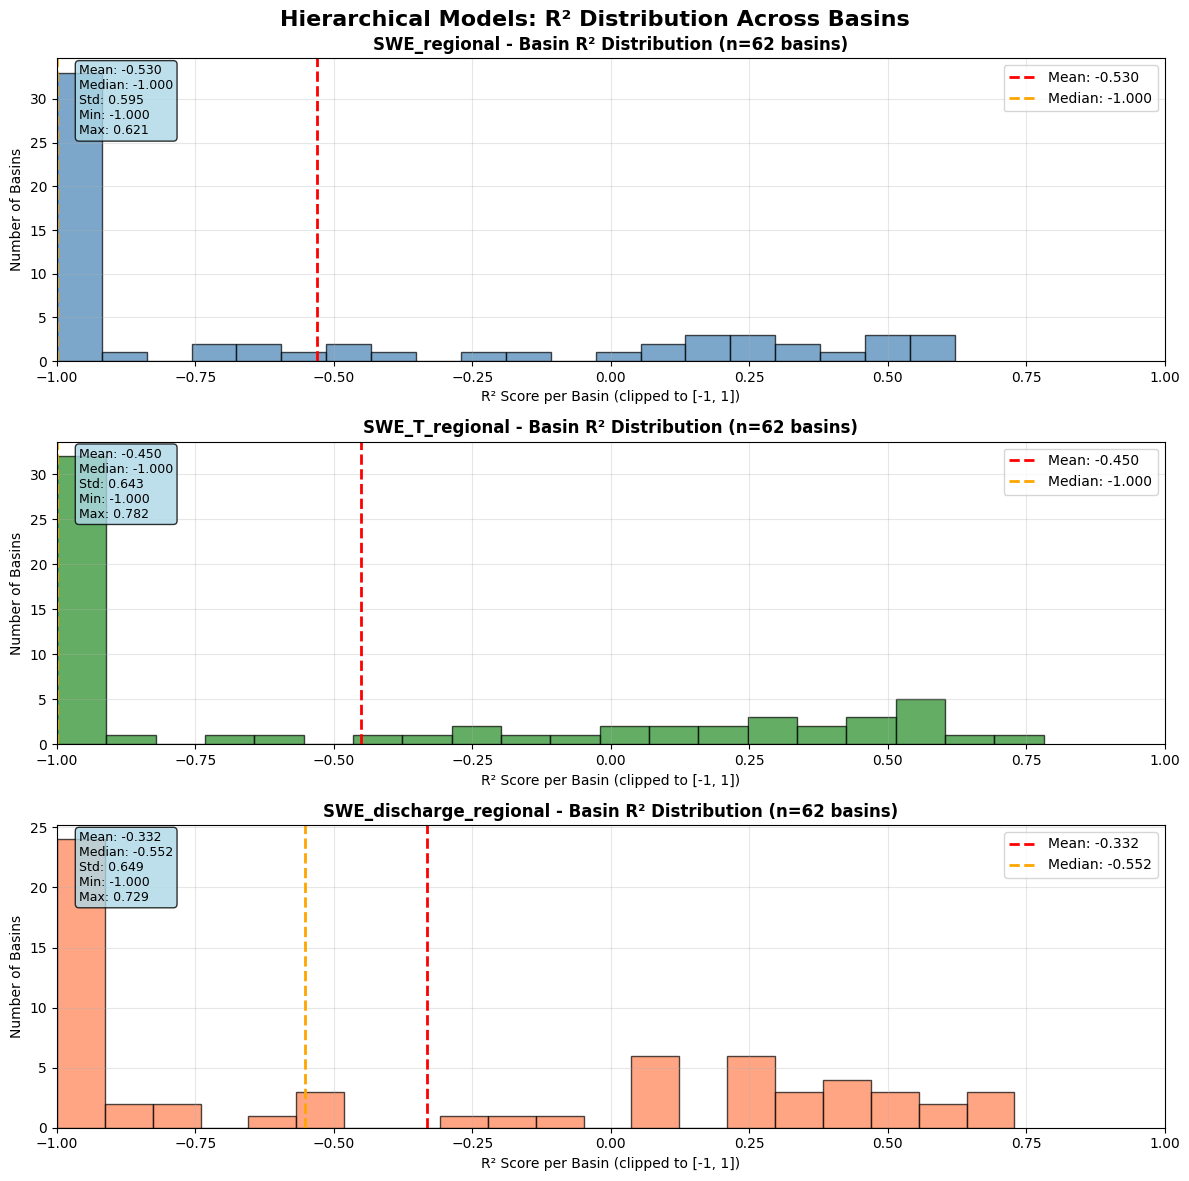

In [25]:
# Visualize R² distributions for each basin across different hierarchical models
if len(all_basin_r2_results) > 0:
    # Create histogram plots for each model showing basin R² distribution
    n_models = len(all_basin_r2_results)
    
    if n_models > 0:
        fig, axes = plt.subplots(n_models, 1, figsize=(12, 4 * n_models))
        
        # Ensure axes is always iterable
        if n_models == 1:
            axes = [axes]
        
        colors = ['steelblue', 'forestgreen', 'coral', 'purple', 'orange']
        
        for i, basin_df in enumerate(all_basin_r2_results):
            ax = axes[i]
            model_name = basin_df['model_name'].iloc[0]
            
            # Plot histogram of basin R² values
            r2_values = basin_df['r2_clipped']
            
            ax.hist(r2_values, bins=20, alpha=0.7, color=colors[i % len(colors)], 
                   edgecolor='black', density=False)
            
            # Add statistics
            mean_r2 = r2_values.mean()
            median_r2 = r2_values.median()
            std_r2 = r2_values.std()
            
            ax.axvline(mean_r2, color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_r2:.3f}')
            ax.axvline(median_r2, color='orange', linestyle='--', linewidth=2, 
                      label=f'Median: {median_r2:.3f}')
            
            # Formatting
            ax.set_title(f'{model_name} - Basin R² Distribution (n={len(r2_values)} basins)', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('R² Score per Basin (clipped to [-1, 1])', fontsize=10)
            ax.set_ylabel('Number of Basins', fontsize=10)
            ax.set_xlim(-1, 1)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
            
            # Add statistics text box
            stats_text = (f'Mean: {mean_r2:.3f}\n'
                         f'Median: {median_r2:.3f}\n'
                         f'Std: {std_r2:.3f}\n'
                         f'Min: {r2_values.min():.3f}\n'
                         f'Max: {r2_values.max():.3f}')
            
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                   verticalalignment='top', bbox=dict(boxstyle='round', 
                   facecolor='lightblue', alpha=0.8))
        
        plt.suptitle('Hierarchical Models: R² Distribution Across Basins', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("No basin R² data available for plotting")

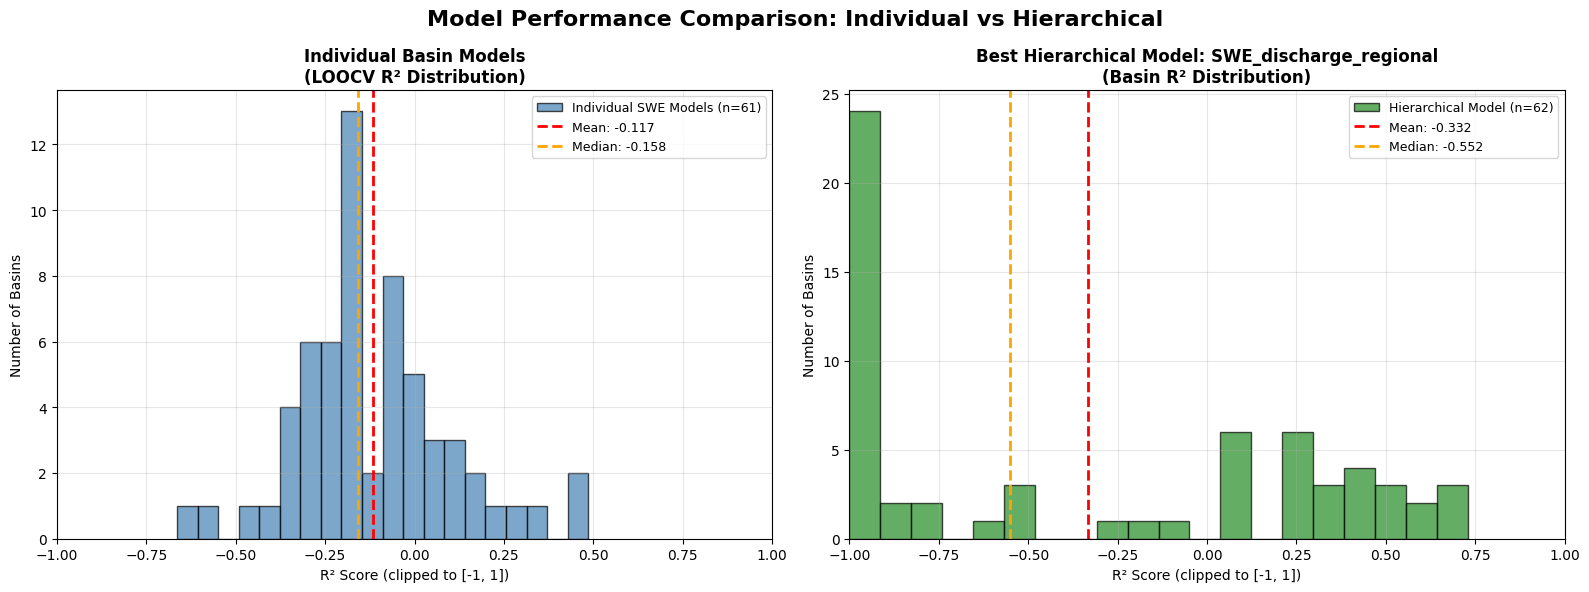


DETAILED BASIN-LEVEL PERFORMANCE COMPARISON

Individual Basin Models (SWE LOOCV):
  Mean R² = -0.1166 ± 0.2201
  Median R² = -0.1582
  Range: [-0.6642, 0.4857]
  N basins = 61

Hierarchical Models (Basin-level R²):
  SWE_regional:
    Mean R² = -0.5303 ± 0.5955
    Median R² = -1.0000
    Range: [-1.0000, 0.6212]
    N basins = 62
    Improvement over individual: -0.4137
  SWE_T_regional:
    Mean R² = -0.4503 ± 0.6433
    Median R² = -1.0000
    Range: [-1.0000, 0.7817]
    N basins = 62
    Improvement over individual: -0.3337
  SWE_discharge_regional:
    Mean R² = -0.3322 ± 0.6493
    Median R² = -0.5517
    Range: [-1.0000, 0.7288]
    N basins = 62
    Improvement over individual: -0.2156


In [26]:
# Compare hierarchical model performance vs individual basin models
if len(all_basin_r2_results) > 0:
    
    # Create comparison plot: Hierarchical vs Individual Basin Models
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Individual basin model R² distribution (from previous LOOCV analysis)
    if 'loocv_df' in locals():
        ax1 = axes[0]
        
        # Plot SWE individual model results
        swe_r2 = loocv_df['r2_swe_clipped']
        
        ax1.hist(swe_r2, bins=20, alpha=0.7, color='steelblue', 
                edgecolor='black', label=f'Individual SWE Models (n={len(swe_r2)})')
        
        ax1.axvline(swe_r2.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {swe_r2.mean():.3f}')
        ax1.axvline(swe_r2.median(), color='orange', linestyle='--', linewidth=2,
                   label=f'Median: {swe_r2.median():.3f}')
        
        ax1.set_title('Individual Basin Models\n(LOOCV R² Distribution)', 
                     fontsize=12, fontweight='bold')
        ax1.set_xlabel('R² Score (clipped to [-1, 1])', fontsize=10)
        ax1.set_ylabel('Number of Basins', fontsize=10)
        ax1.set_xlim(-1, 1)
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=9)
    
    # Plot 2: Best hierarchical model R² distribution
    ax2 = axes[1]
    
    if len(all_basin_r2_results) > 0:
        # Find the model with highest mean basin R²
        model_means = []
        for basin_df in all_basin_r2_results:
            model_name = basin_df['model_name'].iloc[0]
            mean_r2 = basin_df['r2_clipped'].mean()
            model_means.append((model_name, mean_r2, basin_df))
        
        best_model_name, best_mean_r2, best_basin_df = max(model_means, key=lambda x: x[1])
        
        hier_r2 = best_basin_df['r2_clipped']
        
        ax2.hist(hier_r2, bins=20, alpha=0.7, color='forestgreen',
                edgecolor='black', label=f'Hierarchical Model (n={len(hier_r2)})')
        
        ax2.axvline(hier_r2.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {hier_r2.mean():.3f}')
        ax2.axvline(hier_r2.median(), color='orange', linestyle='--', linewidth=2,
                   label=f'Median: {hier_r2.median():.3f}')
        
        ax2.set_title(f'Best Hierarchical Model: {best_model_name}\n(Basin R² Distribution)', 
                     fontsize=12, fontweight='bold')
        ax2.set_xlabel('R² Score (clipped to [-1, 1])', fontsize=10)
        ax2.set_ylabel('Number of Basins', fontsize=10)
        ax2.set_xlim(-1, 1)
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=9)
    
    plt.suptitle('Model Performance Comparison: Individual vs Hierarchical', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison statistics
    print("\n" + "="*80)
    print("DETAILED BASIN-LEVEL PERFORMANCE COMPARISON")
    print("="*80)
    
    if 'loocv_df' in locals():
        individual_r2 = loocv_df['r2_swe_clipped']
        print(f"\nIndividual Basin Models (SWE LOOCV):")
        print(f"  Mean R² = {individual_r2.mean():.4f} ± {individual_r2.std():.4f}")
        print(f"  Median R² = {individual_r2.median():.4f}")
        print(f"  Range: [{individual_r2.min():.4f}, {individual_r2.max():.4f}]")
        print(f"  N basins = {len(individual_r2)}")
    
    print(f"\nHierarchical Models (Basin-level R²):")
    for basin_df in all_basin_r2_results:
        model_name = basin_df['model_name'].iloc[0]
        r2_values = basin_df['r2_clipped']
        
        print(f"  {model_name}:")
        print(f"    Mean R² = {r2_values.mean():.4f} ± {r2_values.std():.4f}")
        print(f"    Median R² = {r2_values.median():.4f}")
        print(f"    Range: [{r2_values.min():.4f}, {r2_values.max():.4f}]")
        print(f"    N basins = {len(r2_values)}")
        
        # Performance improvement calculation
        if 'loocv_df' in locals():
            improvement = r2_values.mean() - individual_r2.mean()
            print(f"    Improvement over individual: {improvement:+.4f}")
else:
    print("No hierarchical basin R² results available for comparison")


Basin-level R² results saved to 'hierarchical_basin_r2_results.csv'

Basin R² Summary Statistics by Model:
                        count    mean  median     std  min     max
model_name                                                        
SWE_T_regional             62 -0.4503 -1.0000  0.6433 -1.0  0.7817
SWE_discharge_regional     62 -0.3322 -0.5517  0.6493 -1.0  0.7288
SWE_regional               62 -0.5303 -1.0000  0.5955 -1.0  0.6212

BEST AND WORST PERFORMING BASINS

SWE_regional:
  Top 3 basins:
    Basin 16100: R² = 0.6212
    Basin 16169: R² = 0.6020
    Basin 16127: R² = 0.5563
  Bottom 3 basins:
    Basin 15312: R² = -1.0000
    Basin 15039: R² = -1.0000
    Basin 15214: R² = -1.0000

SWE_T_regional:
  Top 3 basins:
    Basin 16169: R² = 0.7817
    Basin 16100: R² = 0.6157
    Basin 16139: R² = 0.5632
  Bottom 3 basins:
    Basin 15312: R² = -1.0000
    Basin 15039: R² = -1.0000
    Basin 15214: R² = -1.0000

SWE_discharge_regional:
  Top 3 basins:
    Basin 16487: R² = 0.72

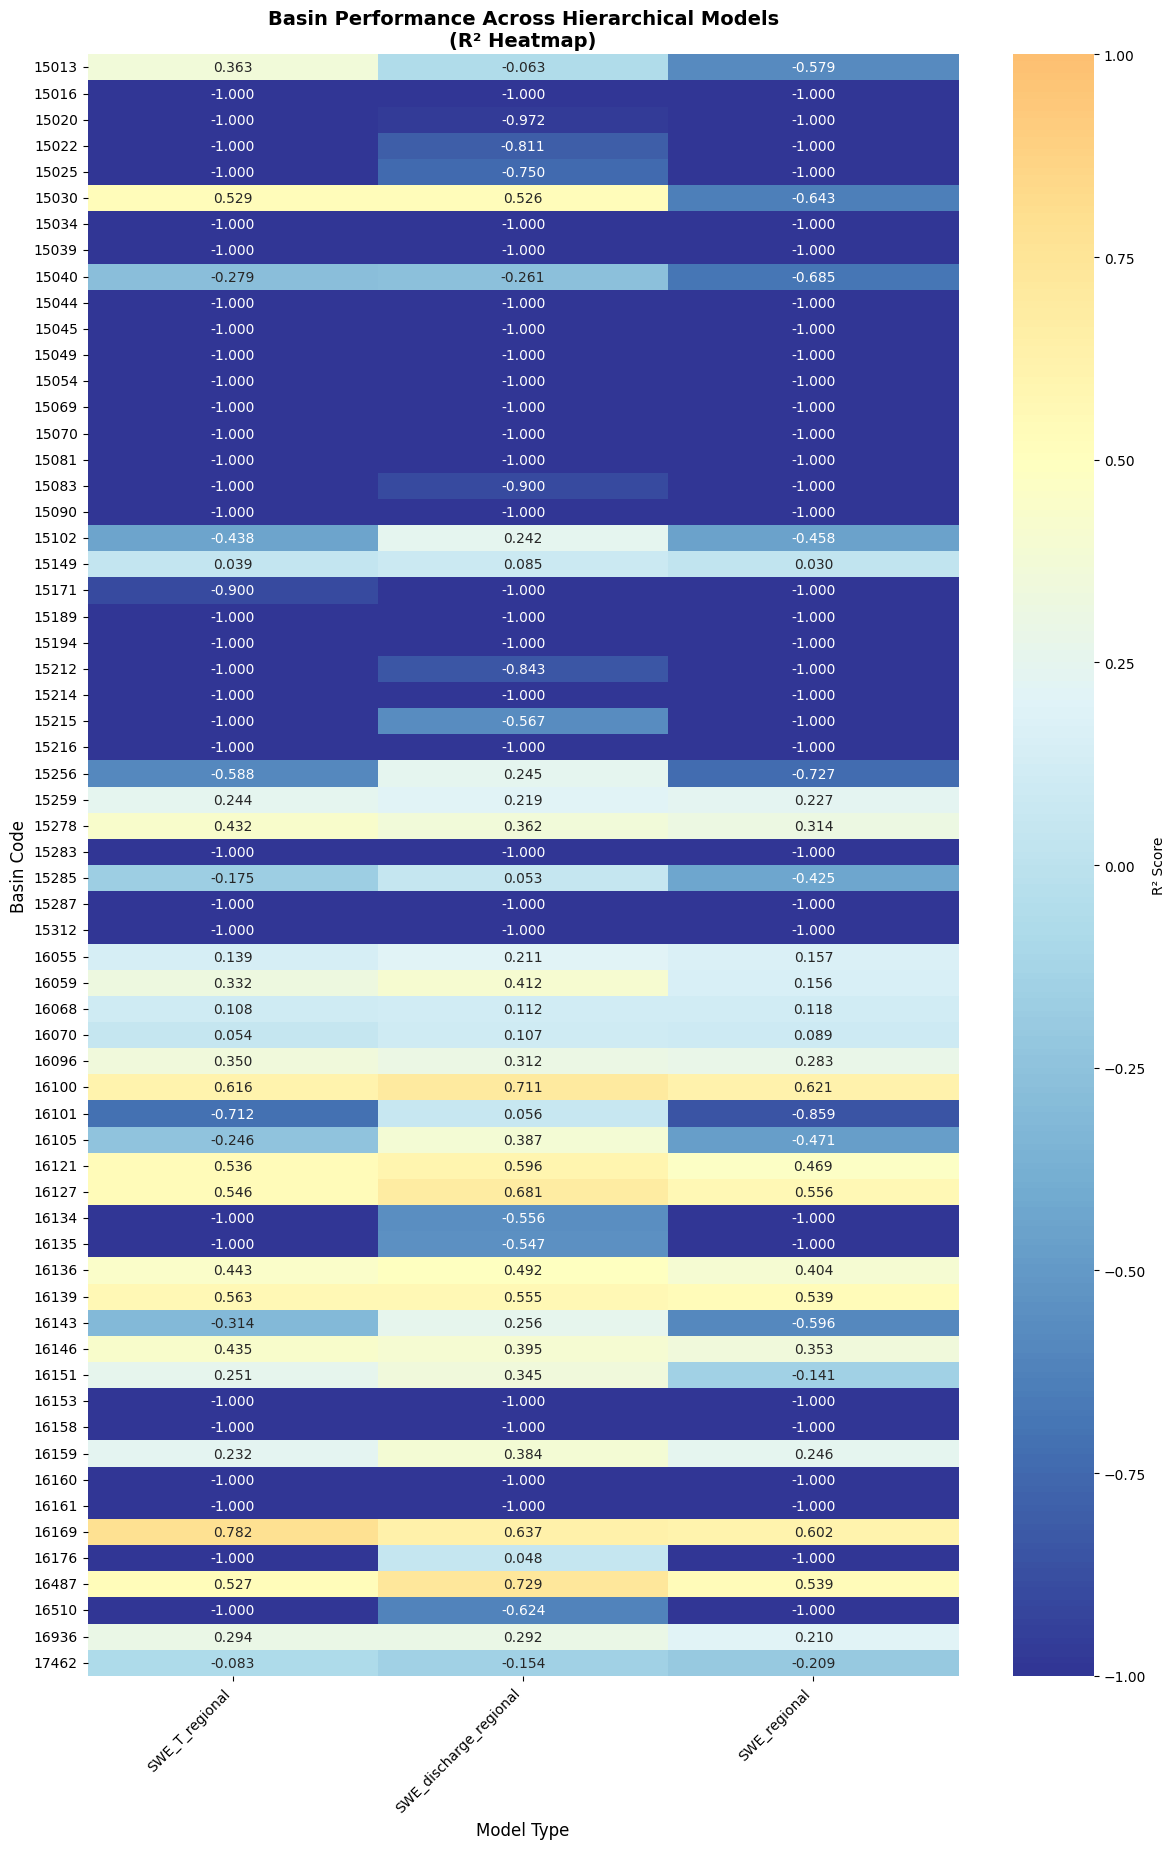


Heatmap shows 62 basins with complete data across all models

BASIN-LEVEL ANALYSIS COMPLETE


In [27]:
# Save detailed basin-level results
if len(all_basin_r2_results) > 0:
    # Save basin R² results to CSV
    basin_r2_combined.to_csv('hierarchical_basin_r2_results.csv', index=False)
    print(f"\nBasin-level R² results saved to 'hierarchical_basin_r2_results.csv'")
    
    # Create summary statistics by model
    basin_summary_stats = basin_r2_combined.groupby('model_name')['r2_clipped'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(4)
    
    print(f"\nBasin R² Summary Statistics by Model:")
    print(basin_summary_stats)
    
    # Identify best and worst performing basins for each model
    print(f"\n" + "="*60)
    print("BEST AND WORST PERFORMING BASINS")
    print("="*60)
    
    for model_name in basin_r2_combined['model_name'].unique():
        model_data = basin_r2_combined[basin_r2_combined['model_name'] == model_name]
        
        # Best performing basins
        best_basins = model_data.nlargest(3, 'r2_clipped')
        worst_basins = model_data.nsmallest(3, 'r2_clipped')
        
        print(f"\n{model_name}:")
        print(f"  Top 3 basins:")
        for _, row in best_basins.iterrows():
            print(f"    Basin {row['code']}: R² = {row['r2_clipped']:.4f}")
        
        print(f"  Bottom 3 basins:")
        for _, row in worst_basins.iterrows():
            print(f"    Basin {row['code']}: R² = {row['r2_clipped']:.4f}")

# Create basin performance heatmap across models
if len(all_basin_r2_results) > 1:
    # Pivot table for heatmap
    pivot_data = basin_r2_combined.pivot(index='code', columns='model_name', values='r2_clipped')
    
    # Only show basins that have data for all models
    complete_basins = pivot_data.dropna()
    
    if len(complete_basins) > 0:
        plt.figure(figsize=(12, max(6, len(complete_basins) * 0.3)))
        
        # Create heatmap
        sns.heatmap(complete_basins, annot=True, cmap='RdYlBu_r', center=0.5, 
                   fmt='.3f', cbar_kws={'label': 'R² Score'}, 
                   vmin=-1, vmax=1)
        
        plt.title('Basin Performance Across Hierarchical Models\n(R² Heatmap)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Model Type', fontsize=12)
        plt.ylabel('Basin Code', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        print(f"\nHeatmap shows {len(complete_basins)} basins with complete data across all models")
    else:
        print("No basins have complete data across all models for heatmap visualization")

print(f"\n" + "="*60)
print("BASIN-LEVEL ANALYSIS COMPLETE")
print("="*60)

## Spatial Correlation Analysis Between Basins

In [28]:
# Create spatial correlation matrix between basin discharge targets
# This analysis will show if there are years where all basins tend to have similarly high or low discharge

# Prepare data: Create a matrix with basins as columns and years as rows
print("Creating spatial correlation matrix between basin discharge targets...")
print(f"Available data shape: {data_march.shape}")
print(f"Available basins: {data_march['code'].nunique()}")
print(f"Date range: {data_march['date'].min()} to {data_march['date'].max()}")

# Create a pivot table: years as rows, basins as columns, discharge as values
discharge_pivot = data_march.pivot_table(
    index=data_march['date'].dt.year, 
    columns='code', 
    values='target',
    aggfunc='mean'  # Average if multiple values per year per basin
)

print(f"\nPivot table shape: {discharge_pivot.shape}")
print(f"Years: {discharge_pivot.index.min()} to {discharge_pivot.index.max()}")
print(f"Number of basins with data: {discharge_pivot.columns.nunique()}")

# Remove basins with too much missing data (less than 50% coverage)
min_years_required = len(discharge_pivot) * 0.5
basins_with_sufficient_data = discharge_pivot.columns[
    discharge_pivot.count() >= min_years_required
]

print(f"\nBasins with sufficient data (>50% coverage): {len(basins_with_sufficient_data)}")

# Filter to basins with sufficient data
discharge_matrix = discharge_pivot[basins_with_sufficient_data].copy()

print(f"Final data matrix shape: {discharge_matrix.shape}")
print(f"Data completeness: {(1 - discharge_matrix.isnull().sum().sum() / discharge_matrix.size) * 100:.1f}%")

# Display first few rows and columns
print(f"\nFirst few rows and columns of discharge matrix:")
print(discharge_matrix.iloc[:5, :5])

Creating spatial correlation matrix between basin discharge targets...
Available data shape: (1534, 17)
Available basins: 63
Date range: 2000-03-31 00:00:00 to 2023-03-31 00:00:00

Pivot table shape: (24, 63)
Years: 2000 to 2023
Number of basins with data: 63

Basins with sufficient data (>50% coverage): 60
Final data matrix shape: (24, 60)
Data completeness: 80.7%

First few rows and columns of discharge matrix:
code      15013      15020      15022      15025      15034
date                                                       
2000  10.715889   7.860000   7.443333  11.836167  10.023667
2001   9.387333  10.269167   8.822167  11.626944   9.100944
2002  10.086889  12.492333  10.076944  12.973111  10.490611
2003  10.247278  13.355333   9.727944  12.819278  12.647333
2004   9.434778  11.416667   8.744056  11.527222  12.944111


In [29]:
# Calculate pairwise correlation matrix between basins
print("Calculating pairwise correlations between basins...")

# Calculate correlation matrix (Pearson correlation)
basin_correlation_matrix = discharge_matrix.corr(method='pearson')

# Also calculate Spearman correlation for comparison (rank-based)
basin_correlation_spearman = discharge_matrix.corr(method='spearman')

print(f"Correlation matrix shape: {basin_correlation_matrix.shape}")
print(f"Number of basin pairs: {(len(basin_correlation_matrix) * (len(basin_correlation_matrix) - 1)) // 2}")

# Summary statistics of correlations
correlation_values = basin_correlation_matrix.values
# Remove diagonal (self-correlations of 1.0)
off_diagonal_correlations = correlation_values[np.triu_indices_from(correlation_values, k=1)]

print(f"\nPearson Correlation Statistics:")
print(f"  Mean correlation: {np.nanmean(off_diagonal_correlations):.3f}")
print(f"  Median correlation: {np.nanmedian(off_diagonal_correlations):.3f}")
print(f"  Std deviation: {np.nanstd(off_diagonal_correlations):.3f}")
print(f"  Min correlation: {np.nanmin(off_diagonal_correlations):.3f}")
print(f"  Max correlation: {np.nanmax(off_diagonal_correlations):.3f}")

# Count strong correlations
strong_positive = np.sum(off_diagonal_correlations > 0.7)
moderate_positive = np.sum((off_diagonal_correlations > 0.3) & (off_diagonal_correlations <= 0.7))
weak_correlations = np.sum((off_diagonal_correlations >= -0.3) & (off_diagonal_correlations <= 0.3))
negative_correlations = np.sum(off_diagonal_correlations < -0.3)

total_pairs = len(off_diagonal_correlations)
print(f"\nCorrelation Distribution:")
print(f"  Strong positive (>0.7): {strong_positive} ({strong_positive/total_pairs*100:.1f}%)")
print(f"  Moderate positive (0.3-0.7): {moderate_positive} ({moderate_positive/total_pairs*100:.1f}%)")
print(f"  Weak (-0.3 to 0.3): {weak_correlations} ({weak_correlations/total_pairs*100:.1f}%)")
print(f"  Negative (<-0.3): {negative_correlations} ({negative_correlations/total_pairs*100:.1f}%)")

Calculating pairwise correlations between basins...
Correlation matrix shape: (60, 60)
Number of basin pairs: 1770

Pearson Correlation Statistics:
  Mean correlation: 0.311
  Median correlation: 0.360
  Std deviation: 0.331
  Min correlation: -0.734
  Max correlation: 0.973

Correlation Distribution:
  Strong positive (>0.7): 190 (10.7%)
  Moderate positive (0.3-0.7): 800 (45.2%)
  Weak (-0.3 to 0.3): 695 (39.3%)
  Negative (<-0.3): 85 (4.8%)


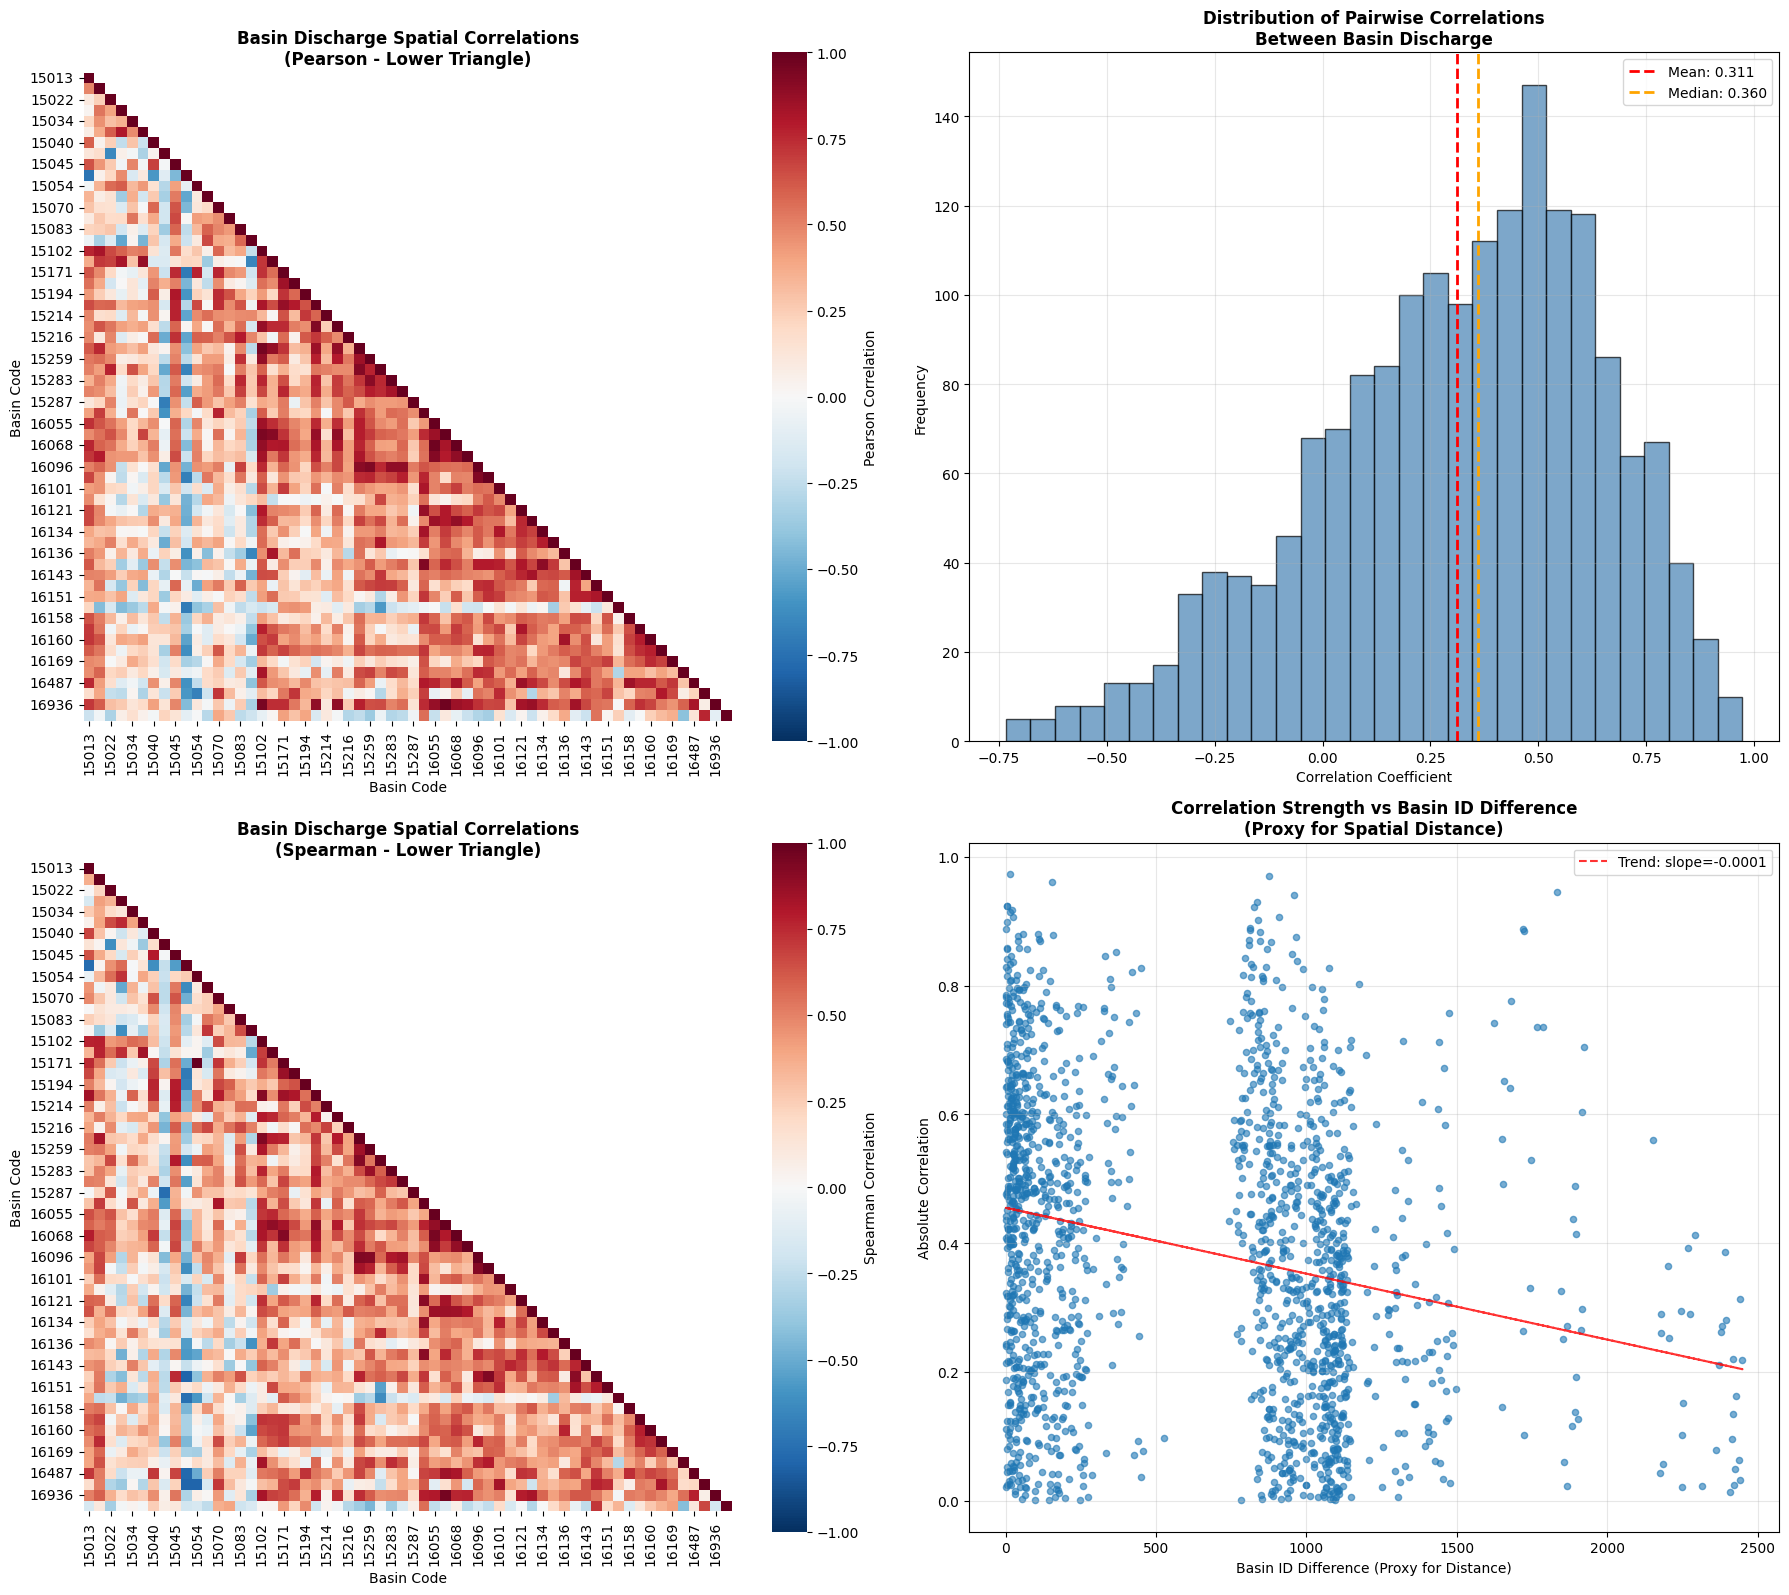

In [30]:
# Visualize the spatial correlation matrix with heatmap
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Plot 1: Full correlation matrix heatmap (Pearson)
ax1 = axes[0, 0]
mask = np.triu(np.ones_like(basin_correlation_matrix, dtype=bool), k=1)  # Mask upper triangle
sns.heatmap(basin_correlation_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0, 
            square=True, ax=ax1, cbar_kws={'label': 'Pearson Correlation'}, 
            vmin=-1, vmax=1)
ax1.set_title('Basin Discharge Spatial Correlations\n(Pearson - Lower Triangle)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Basin Code', fontsize=10)
ax1.set_ylabel('Basin Code', fontsize=10)

# Plot 2: Correlation distribution histogram
ax2 = axes[0, 1]
ax2.hist(off_diagonal_correlations, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(np.nanmean(off_diagonal_correlations), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.nanmean(off_diagonal_correlations):.3f}')
ax2.axvline(np.nanmedian(off_diagonal_correlations), color='orange', linestyle='--', linewidth=2, 
           label=f'Median: {np.nanmedian(off_diagonal_correlations):.3f}')
ax2.set_title('Distribution of Pairwise Correlations\nBetween Basin Discharge', fontsize=12, fontweight='bold')
ax2.set_xlabel('Correlation Coefficient', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Spearman correlation matrix for comparison
ax3 = axes[1, 0]
mask_spearman = np.triu(np.ones_like(basin_correlation_spearman, dtype=bool), k=1)
sns.heatmap(basin_correlation_spearman, mask=mask_spearman, annot=False, cmap='RdBu_r', center=0, 
            square=True, ax=ax3, cbar_kws={'label': 'Spearman Correlation'}, 
            vmin=-1, vmax=1)
ax3.set_title('Basin Discharge Spatial Correlations\n(Spearman - Lower Triangle)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Basin Code', fontsize=10)
ax3.set_ylabel('Basin Code', fontsize=10)

# Plot 4: Correlation vs Geographic Distance (if we had coordinates)
ax4 = axes[1, 1]
# For now, we'll show a scatter plot of correlation strength vs basin ID difference
# This gives a rough proxy for potential geographic effects
basin_ids = basin_correlation_matrix.columns.values
correlation_pairs = []
id_differences = []

for i in range(len(basin_ids)):
    for j in range(i + 1, len(basin_ids)):
        basin_i, basin_j = basin_ids[i], basin_ids[j]
        correlation = basin_correlation_matrix.loc[basin_i, basin_j]
        if not np.isnan(correlation):
            correlation_pairs.append(abs(correlation))  # Use absolute correlation
            id_differences.append(abs(basin_i - basin_j))

ax4.scatter(id_differences, correlation_pairs, alpha=0.6, s=20)
ax4.set_xlabel('Basin ID Difference (Proxy for Distance)', fontsize=10)
ax4.set_ylabel('Absolute Correlation', fontsize=10)
ax4.set_title('Correlation Strength vs Basin ID Difference\n(Proxy for Spatial Distance)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add trend line
if len(correlation_pairs) > 0:
    z = np.polyfit(id_differences, correlation_pairs, 1)
    p = np.poly1d(z)
    ax4.plot(id_differences, p(id_differences), "r--", alpha=0.8, 
            label=f'Trend: slope={z[0]:.4f}')
    ax4.legend()

plt.tight_layout()
plt.show()

Performing hierarchical clustering of basins based on discharge correlations...

Cluster assignments (k=4):
  Cluster 1: [15034, 15040, 15045, 15069, 15070, 15081, 15083, 15090, 15194, 15214, 15216] (n=11)
  Cluster 2: [15013, 15049, 15171, 15189, 15278, 15312, 16101, 16105, 16121, 16127, 16134, 16135, 16136, 16139, 16143, 16146, 16151, 16153, 16158, 16159, 16160, 16161, 16169, 16487, 16510, 17462] (n=26)
  Cluster 3: [15020, 15102, 15212, 15215, 15256, 15259, 15283, 15285, 16055, 16059, 16068, 16070, 16096, 16100, 16176, 16936] (n=16)
  Cluster 4: [15022, 15025, 15039, 15044, 15054, 15149, 15287] (n=7)


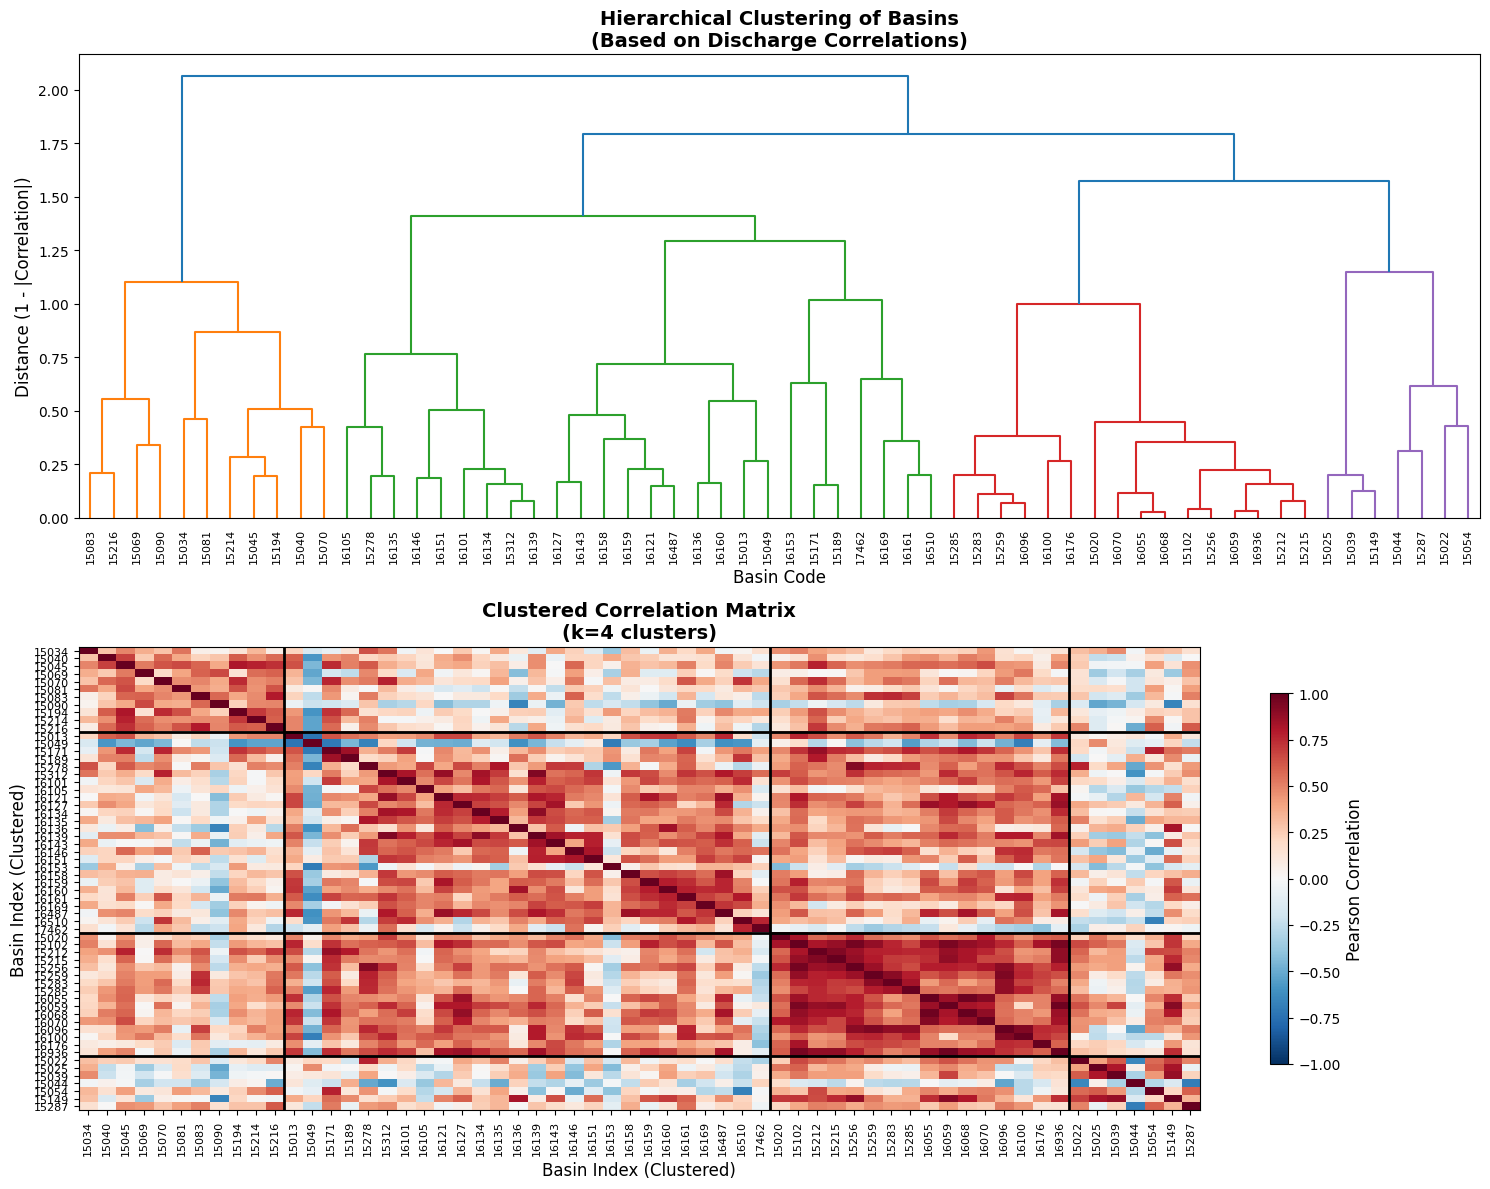

In [31]:
# Identify clusters of highly correlated basins
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

print("Performing hierarchical clustering of basins based on discharge correlations...")

# Convert correlation matrix to distance matrix (1 - correlation)
distance_matrix = 1 - basin_correlation_matrix.abs()

# Handle NaN values by setting them to maximum distance
distance_matrix = distance_matrix.fillna(1.0)

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# Create dendrogram plot
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot dendrogram
ax1 = axes[0]
dendrogram(linkage_matrix, labels=basin_correlation_matrix.columns.astype(str), 
           ax=ax1, leaf_rotation=90, leaf_font_size=8)
ax1.set_title('Hierarchical Clustering of Basins\n(Based on Discharge Correlations)', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('Basin Code', fontsize=12)
ax1.set_ylabel('Distance (1 - |Correlation|)', fontsize=12)

# Get cluster assignments (try different numbers of clusters)
n_clusters = 4
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Create a mapping of basin to cluster
basin_to_cluster = dict(zip(basin_correlation_matrix.columns, cluster_labels))

print(f"\nCluster assignments (k={n_clusters}):")
for cluster_id in range(1, n_clusters + 1):
    basins_in_cluster = [basin for basin, cluster in basin_to_cluster.items() 
                        if cluster == cluster_id]
    print(f"  Cluster {cluster_id}: {basins_in_cluster} (n={len(basins_in_cluster)})")

# Plot clustered correlation matrix
ax2 = axes[1]
# Reorder the correlation matrix by cluster
cluster_order = []
for cluster_id in range(1, n_clusters + 1):
    basins_in_cluster = [basin for basin, cluster in basin_to_cluster.items() 
                        if cluster == cluster_id]
    cluster_order.extend(sorted(basins_in_cluster))

clustered_corr_matrix = basin_correlation_matrix.loc[cluster_order, cluster_order]

# Create heatmap with cluster boundaries
im = ax2.imshow(clustered_corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Add cluster boundaries
cluster_boundaries = []
current_pos = 0
for cluster_id in range(1, n_clusters + 1):
    basins_in_cluster = [basin for basin, cluster in basin_to_cluster.items() 
                        if cluster == cluster_id]
    current_pos += len(basins_in_cluster)
    if cluster_id < n_clusters:  # Don't add line after last cluster
        ax2.axhline(current_pos - 0.5, color='black', linewidth=2)
        ax2.axvline(current_pos - 0.5, color='black', linewidth=2)

ax2.set_title(f'Clustered Correlation Matrix\n(k={n_clusters} clusters)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Basin Index (Clustered)', fontsize=12)
ax2.set_ylabel('Basin Index (Clustered)', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_label('Pearson Correlation', fontsize=12)

# Set tick labels
ax2.set_xticks(range(len(cluster_order)))
ax2.set_yticks(range(len(cluster_order)))
ax2.set_xticklabels(cluster_order, rotation=90, fontsize=8)
ax2.set_yticklabels(cluster_order, fontsize=8)

plt.tight_layout()
plt.show()

Analyzing temporal synchronization patterns...

Temporal Synchronization Analysis:
  Years with high discharge (>80th percentile): [2002, 2006, 2010, 2016, 2023]
  Years with low discharge (<20th percentile): [2001, 2003, 2014, 2017, 2018]
  Most synchronized years (low CV): [2003, 2008, 2014, 2017, 2018, 2019, 2020]
  Least synchronized years (high CV): [2001, 2004, 2005, 2006, 2009, 2010, 2013]


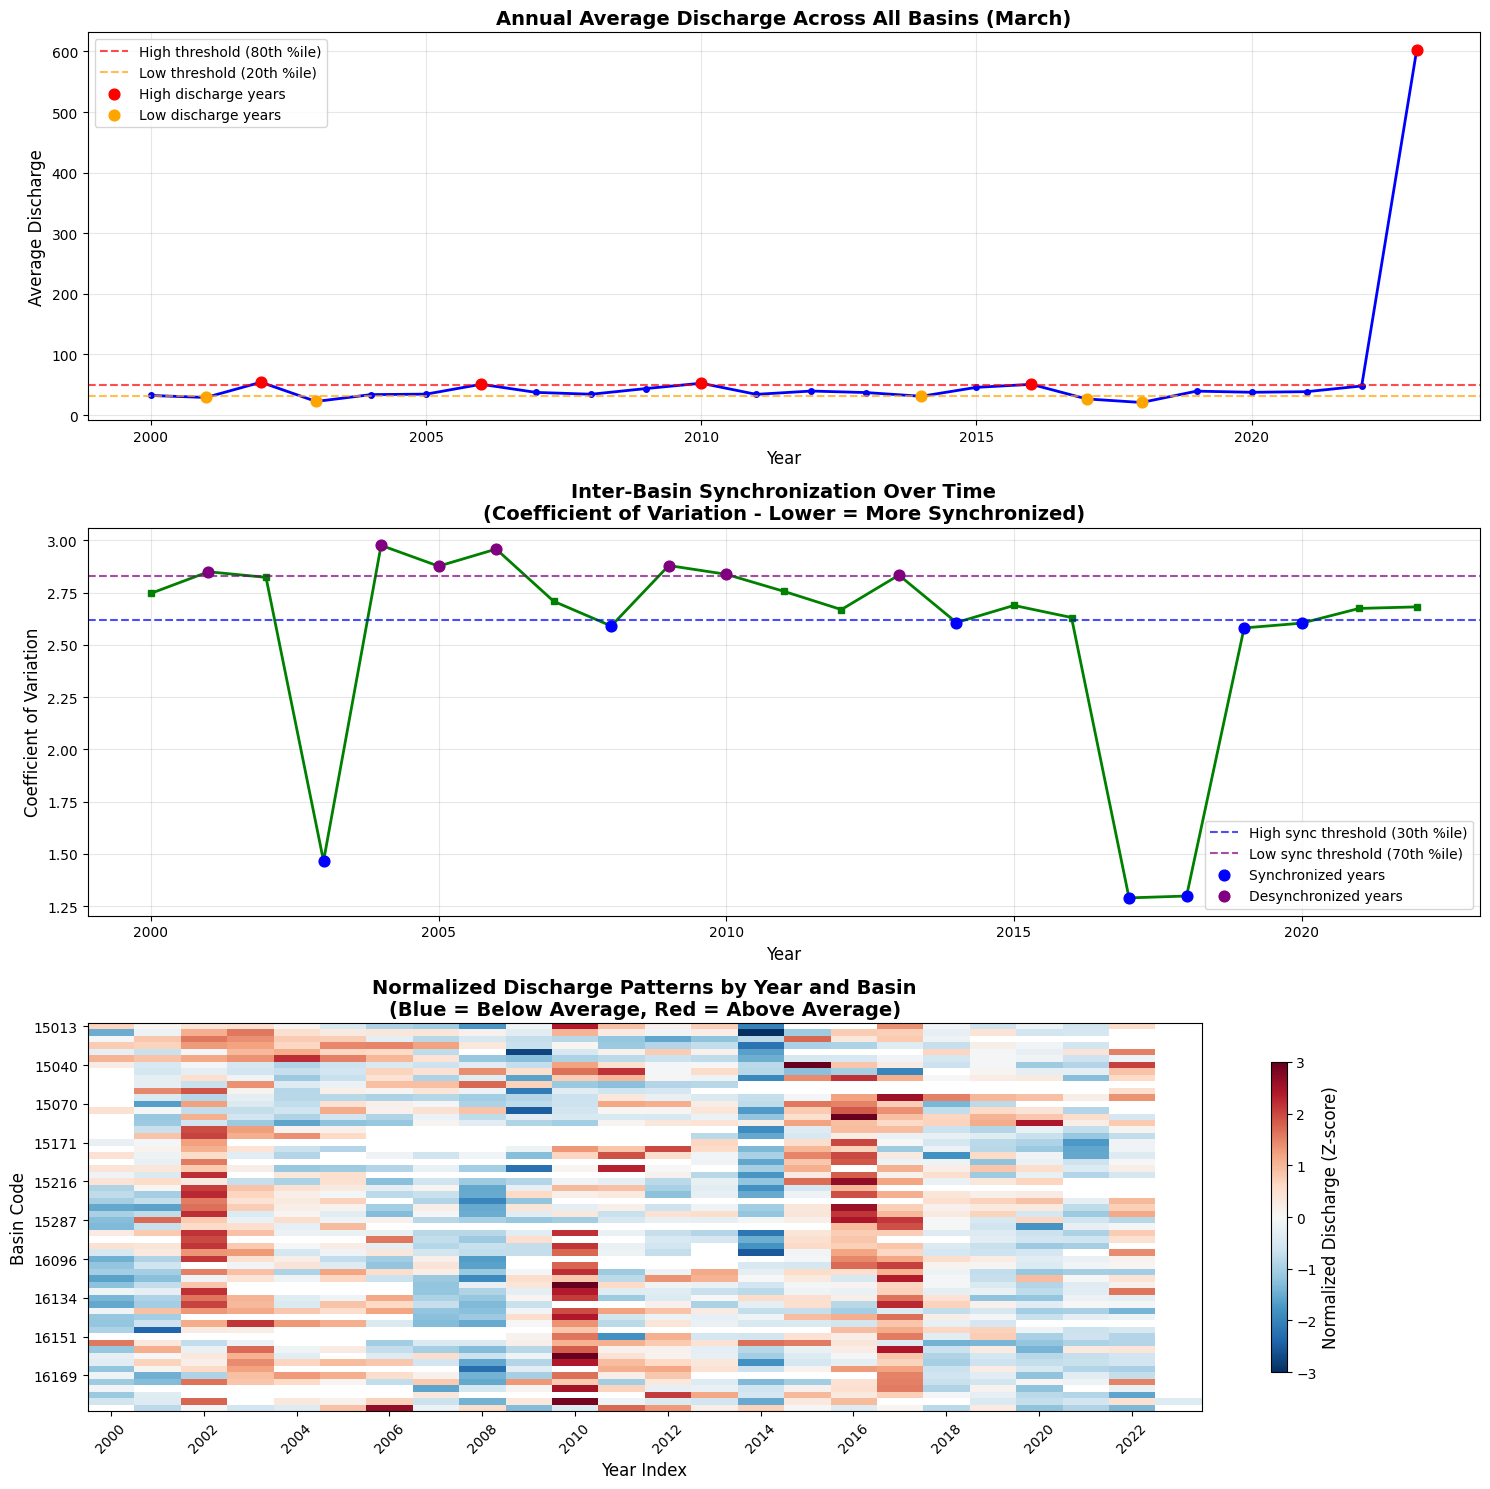

In [32]:
# Analyze temporal patterns: Identify years with synchronized high/low discharge
print("Analyzing temporal synchronization patterns...")

# Calculate annual average discharge across all basins for each year
annual_avg_discharge = discharge_matrix.mean(axis=1, skipna=True)
annual_std_discharge = discharge_matrix.std(axis=1, skipna=True)

# Identify years with particularly high or low average discharge
discharge_threshold_high = annual_avg_discharge.quantile(0.8)  # Top 20%
discharge_threshold_low = annual_avg_discharge.quantile(0.2)   # Bottom 20%

high_discharge_years = annual_avg_discharge[annual_avg_discharge >= discharge_threshold_high].index
low_discharge_years = annual_avg_discharge[annual_avg_discharge <= discharge_threshold_low].index

print(f"\nTemporal Synchronization Analysis:")
print(f"  Years with high discharge (>80th percentile): {list(high_discharge_years)}")
print(f"  Years with low discharge (<20th percentile): {list(low_discharge_years)}")

# Calculate coefficient of variation across basins for each year (measure of synchronization)
# Lower CV = more synchronized (all basins similar), Higher CV = less synchronized
annual_cv = annual_std_discharge / annual_avg_discharge
synchronized_years = annual_cv[annual_cv <= annual_cv.quantile(0.3)].index  # Most synchronized 30%
desynchronized_years = annual_cv[annual_cv >= annual_cv.quantile(0.7)].index  # Least synchronized 30%

print(f"  Most synchronized years (low CV): {list(synchronized_years)}")
print(f"  Least synchronized years (high CV): {list(desynchronized_years)}")

# Create temporal analysis plots
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Time series of annual average discharge
ax1 = axes[0]
ax1.plot(annual_avg_discharge.index, annual_avg_discharge.values, 'b-', linewidth=2, marker='o', markersize=4)
ax1.axhline(discharge_threshold_high, color='red', linestyle='--', alpha=0.7, label='High threshold (80th %ile)')
ax1.axhline(discharge_threshold_low, color='orange', linestyle='--', alpha=0.7, label='Low threshold (20th %ile)')

# Highlight extreme years
ax1.scatter(high_discharge_years, annual_avg_discharge[high_discharge_years], 
           color='red', s=60, zorder=5, label='High discharge years')
ax1.scatter(low_discharge_years, annual_avg_discharge[low_discharge_years], 
           color='orange', s=60, zorder=5, label='Low discharge years')

ax1.set_title('Annual Average Discharge Across All Basins (March)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Average Discharge', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Coefficient of variation over time
ax2 = axes[1]
ax2.plot(annual_cv.index, annual_cv.values, 'g-', linewidth=2, marker='s', markersize=4)
ax2.axhline(annual_cv.quantile(0.3), color='blue', linestyle='--', alpha=0.7, label='High sync threshold (30th %ile)')
ax2.axhline(annual_cv.quantile(0.7), color='purple', linestyle='--', alpha=0.7, label='Low sync threshold (70th %ile)')

# Highlight synchronized/desynchronized years
ax2.scatter(synchronized_years, annual_cv[synchronized_years], 
           color='blue', s=60, zorder=5, label='Synchronized years')
ax2.scatter(desynchronized_years, annual_cv[desynchronized_years], 
           color='purple', s=60, zorder=5, label='Desynchronized years')

ax2.set_title('Inter-Basin Synchronization Over Time\n(Coefficient of Variation - Lower = More Synchronized)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Coefficient of Variation', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Heatmap of discharge by year and basin
ax3 = axes[2]
# Normalize discharge for better visualization (z-score by basin)
discharge_normalized = discharge_matrix.sub(discharge_matrix.mean(axis=0), axis=1).div(discharge_matrix.std(axis=0), axis=1)

im = ax3.imshow(discharge_normalized.T.values, cmap='RdBu_r', aspect='auto', vmin=-3, vmax=3)
ax3.set_title('Normalized Discharge Patterns by Year and Basin\n(Blue = Below Average, Red = Above Average)', 
             fontsize=14, fontweight='bold')
ax3.set_xlabel('Year Index', fontsize=12)
ax3.set_ylabel('Basin Code', fontsize=12)

# Set tick labels
years = discharge_normalized.index.values
ax3.set_xticks(range(0, len(years), max(1, len(years)//10)))
ax3.set_xticklabels([years[i] for i in range(0, len(years), max(1, len(years)//10))], rotation=45)

basins = discharge_normalized.columns.values
ax3.set_yticks(range(0, len(basins), max(1, len(basins)//10)))
ax3.set_yticklabels([basins[i] for i in range(0, len(basins), max(1, len(basins)//10))])

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Normalized Discharge (Z-score)', fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
# Export spatial correlation results and create summary tables
print("Creating summary tables and saving results...")

# 1. Create summary table of highest and lowest correlations
n_top_pairs = 10  # Show top 10 pairs for each category

# Get all correlation pairs with basin names
correlation_summary = []
basin_names = basin_correlation_matrix.columns

for i in range(len(basin_names)):
    for j in range(i + 1, len(basin_names)):
        basin_1, basin_2 = basin_names[i], basin_names[j]
        correlation = basin_correlation_matrix.loc[basin_1, basin_2]
        
        if not np.isnan(correlation):
            correlation_summary.append({
                'Basin_1': basin_1,
                'Basin_2': basin_2,
                'Pearson_Correlation': correlation,
                'Spearman_Correlation': basin_correlation_spearman.loc[basin_1, basin_2],
                'Correlation_Strength': 'Strong' if abs(correlation) > 0.7 else 
                                      'Moderate' if abs(correlation) > 0.3 else 'Weak',
                'Correlation_Type': 'Positive' if correlation > 0 else 'Negative'
            })

correlation_df = pd.DataFrame(correlation_summary)

# Sort by correlation strength
correlation_df_sorted = correlation_df.sort_values('Pearson_Correlation', ascending=False)

print(f"\nTop {n_top_pairs} Most Positively Correlated Basin Pairs:")
print("=" * 70)
top_positive = correlation_df_sorted.head(n_top_pairs)
for _, row in top_positive.iterrows():
    print(f"  Basins {int(row['Basin_1'])} - {int(row['Basin_2'])}: r = {row['Pearson_Correlation']:.3f} ({row['Correlation_Strength']})")

print(f"\nTop {n_top_pairs} Most Negatively Correlated Basin Pairs:")
print("=" * 70)
top_negative = correlation_df_sorted.tail(n_top_pairs)
for _, row in top_negative.iterrows():
    print(f"  Basins {int(row['Basin_1'])} - {int(row['Basin_2'])}: r = {row['Pearson_Correlation']:.3f} ({row['Correlation_Strength']})")

# 2. Save detailed results to CSV files
print(f"\nSaving results to CSV files...")

# Save correlation matrix
basin_correlation_matrix.to_csv('basin_spatial_correlation_matrix.csv')
print("  - Basin correlation matrix saved to 'basin_spatial_correlation_matrix.csv'")

# Save pairwise correlation summary
correlation_df_sorted.to_csv('basin_pairwise_correlations.csv', index=False)
print("  - Pairwise correlations saved to 'basin_pairwise_correlations.csv'")

# Save cluster assignments
cluster_df = pd.DataFrame([
    {'Basin_Code': basin, 'Cluster': cluster} 
    for basin, cluster in basin_to_cluster.items()
])
cluster_df = cluster_df.sort_values('Cluster')
cluster_df.to_csv('basin_cluster_assignments.csv', index=False)
print("  - Cluster assignments saved to 'basin_cluster_assignments.csv'")

# Save temporal analysis results
temporal_df = pd.DataFrame({
    'Year': annual_avg_discharge.index,
    'Average_Discharge': annual_avg_discharge.values,
    'Std_Discharge': annual_std_discharge.values,
    'Coefficient_Variation': annual_cv.values,
    'Discharge_Category': ['High' if year in high_discharge_years else 
                          'Low' if year in low_discharge_years else 'Normal' 
                          for year in annual_avg_discharge.index],
    'Synchronization': ['High' if year in synchronized_years else 
                       'Low' if year in desynchronized_years else 'Medium'
                       for year in annual_avg_discharge.index]
})
temporal_df.to_csv('basin_temporal_synchronization.csv', index=False)
print("  - Temporal synchronization results saved to 'basin_temporal_synchronization.csv'")

# 3. Print final summary statistics
print(f"\n" + "=" * 70)
print("SPATIAL CORRELATION ANALYSIS SUMMARY")
print("=" * 70)
print(f"Total basins analyzed: {len(basin_correlation_matrix)}")
print(f"Total basin pairs: {len(correlation_df)}")
print(f"Data coverage period: {discharge_matrix.index.min()} - {discharge_matrix.index.max()}")

print(f"\nCorrelation Distribution:")
print(f"  Strong positive correlations (>0.7): {len(correlation_df[correlation_df['Pearson_Correlation'] > 0.7])}")
print(f"  Moderate positive correlations (0.3-0.7): {len(correlation_df[(correlation_df['Pearson_Correlation'] > 0.3) & (correlation_df['Pearson_Correlation'] <= 0.7)])}")
print(f"  Weak correlations (-0.3 to 0.3): {len(correlation_df[(correlation_df['Pearson_Correlation'] >= -0.3) & (correlation_df['Pearson_Correlation'] <= 0.3)])}")
print(f"  Negative correlations (<-0.3): {len(correlation_df[correlation_df['Pearson_Correlation'] < -0.3])}")

print(f"\nTemporal Synchronization:")
print(f"  High discharge years: {len(high_discharge_years)} ({', '.join(map(str, high_discharge_years))})")
print(f"  Low discharge years: {len(low_discharge_years)} ({', '.join(map(str, low_discharge_years))})")
print(f"  Highly synchronized years: {len(synchronized_years)}")
print(f"  Poorly synchronized years: {len(desynchronized_years)}")

print(f"\nCluster Analysis:")
for cluster_id in range(1, n_clusters + 1):
    basins_in_cluster = len([basin for basin, cluster in basin_to_cluster.items() if cluster == cluster_id])
    print(f"  Cluster {cluster_id}: {basins_in_cluster} basins")

print(f"\n" + "=" * 70)

Creating summary tables and saving results...

Top 10 Most Positively Correlated Basin Pairs:
  Basins 16055 - 16068: r = 0.973 (Strong)
  Basins 16059 - 16936: r = 0.970 (Strong)
  Basins 15102 - 15256: r = 0.961 (Strong)
  Basins 15102 - 16936: r = 0.946 (Strong)
  Basins 15102 - 16059: r = 0.942 (Strong)
  Basins 15259 - 16096: r = 0.931 (Strong)
  Basins 16096 - 16100: r = 0.924 (Strong)
  Basins 15212 - 15215: r = 0.924 (Strong)
  Basins 15312 - 16139: r = 0.922 (Strong)
  Basins 15256 - 15278: r = 0.918 (Strong)

Top 10 Most Negatively Correlated Basin Pairs:
  Basins 15022 - 15044: r = -0.648 (Moderate)
  Basins 15090 - 15149: r = -0.663 (Moderate)
  Basins 15090 - 16136: r = -0.663 (Moderate)
  Basins 15049 - 15278: r = -0.666 (Moderate)
  Basins 15054 - 16510: r = -0.672 (Moderate)
  Basins 15049 - 16100: r = -0.687 (Moderate)
  Basins 15044 - 15287: r = -0.688 (Moderate)
  Basins 15049 - 16153: r = -0.701 (Strong)
  Basins 15049 - 15171: r = -0.703 (Strong)
  Basins 15013 - 1